In [3]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image
from sklearn import preprocessing
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten
from tensorflow.keras.applications import NASNetMobile, DenseNet121, ResNet50

2025-02-25 17:13:32.681280: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-25 17:13:32.697262: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-25 17:13:32.872590: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-25 17:13:33.054081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740521613.211408   70159 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740521613.25

In [4]:
train_path = os.path.join('/root/covid-classification/MajorProject')

In [5]:
neg_images = os.listdir(train_path);
post_images = os.listdir(train_path + '/Positive');
neg_images_one = os.listdir(train_path + '/Negative');

In [6]:
WIDTH = 224
HEIGHT = 224
CHANNEL = 3

In [7]:
neg_df_one = { 'id': neg_images_one}
neg_df_one = pd.DataFrame(neg_df_one)
neg_df_one['label'] = 0;
print(neg_df_one)

                   id  label
0   1646601844180.jpg      0
1   1646599778299.jpg      0
2   1646601843873.jpg      0
3   1646601843989.jpg      0
4   1646600323435.jpg      0
5   1646601843893.jpg      0
6   1646601844113.jpg      0
7   1646601844022.jpg      0
8   1646601843934.jpg      0
9   1646601844163.jpg      0
10  1646601843851.jpg      0
11  1646601844239.jpg      0
12  1646601843954.jpg      0
13  1646601844037.jpg      0
14  1646601843826.jpg      0
15  1646601843777.jpg      0
16  1646601843802.jpg      0
17  1646601844209.jpg      0
18  1646601844006.jpg      0
19  1646601843912.jpg      0
20  1646601844194.jpg      0
21  1646601844098.jpg      0
22  1646601844147.jpg      0
23  1646601843972.jpg      0
24  1646601844081.jpg      0


In [8]:
neg_ids_one = neg_df_one['id']
neg_labels_one = np.array(neg_df_one['label'])
neg_labels_one[:5]

array([0, 0, 0, 0, 0])

In [9]:
neg_ids_one

0     1646601844180.jpg
1     1646599778299.jpg
2     1646601843873.jpg
3     1646601843989.jpg
4     1646600323435.jpg
5     1646601843893.jpg
6     1646601844113.jpg
7     1646601844022.jpg
8     1646601843934.jpg
9     1646601844163.jpg
10    1646601843851.jpg
11    1646601844239.jpg
12    1646601843954.jpg
13    1646601844037.jpg
14    1646601843826.jpg
15    1646601843777.jpg
16    1646601843802.jpg
17    1646601844209.jpg
18    1646601844006.jpg
19    1646601843912.jpg
20    1646601844194.jpg
21    1646601844098.jpg
22    1646601844147.jpg
23    1646601843972.jpg
24    1646601844081.jpg
Name: id, dtype: object

In [10]:
NUM_ITEMS_NEG_ONE = len(neg_df_one)
NUM_ITEMS_NEG_ONE

25

In [11]:
# Building data list
data_neg_one = []
for i in range(NUM_ITEMS_NEG_ONE):
    image = Image.open(train_path + '/Negative/' + neg_ids_one[i])
    # resize the image and convert into numpy array (224, 224)
    image = np.array(image.resize((WIDTH, HEIGHT)))
    data_neg_one.append(image)
data_neg_one = np.array(data_neg_one)

In [12]:
len(data_neg_one)

25

In [13]:
post_df = { 'id': post_images}
post_df = pd.DataFrame(post_df)
post_df['label'] = 1;
print(post_df)

                    id  label
0    1649330010561.jpg      1
1    1649330009917.jpg      1
2    1646476114019.jpg      1
3    1649325344586.jpg      1
4    1650442222410.jpg      1
..                 ...    ...
295  1649325344436.jpg      1
296  1650183370859.jpg      1
297  1649330011438.jpg      1
298  1650442223318.jpg      1
299  1646476113889.jpg      1

[300 rows x 2 columns]


In [14]:
post_ids = post_df['id']
post_labels = np.array(post_df['label'])
post_labels[:5]

array([1, 1, 1, 1, 1])

In [15]:
NUM_ITEMS_POST = len(post_df)
NUM_ITEMS_POST

300

In [16]:
# Building positive data list
post_data = []
for i in range(NUM_ITEMS_POST):
    image = Image.open(train_path + '/Positive/' + post_ids[i])
    # resize the image and convert into numpy array (224, 224)
    image = np.array(image.resize((WIDTH, HEIGHT)))
    post_data.append(image)
post_data = np.array(post_data)

In [17]:
len(post_data)

300

In [18]:
data = np.concatenate((data_neg_one, post_data))

In [19]:
len(data)

325

In [20]:
data.ndim

4

In [21]:
frames = [neg_df_one, post_df]
df = pd.concat(frames)
df

,id,label
0,1646601844180.jpg,0
1,1646599778299.jpg,0
2,1646601843873.jpg,0
3,1646601843989.jpg,0
4,1646600323435.jpg,0
...,...,...
295,1649325344436.jpg,1
296,1650183370859.jpg,1
297,1649330011438.jpg,1
298,1650442223318.jpg,1


In [22]:
labels = df['label']

In [23]:
print('Data: ', data.shape)
print('Labels: ', labels.shape)

Data:  (325, 224, 224, 3)
Labels:  (325,)


In [24]:
# Splitting data set 
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True)
# Scaling the data
X_train = X_train / 255
X_test = X_test / 255
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(260, 224, 224, 3) (65, 224, 224, 3) (260,) (65,)


In [25]:
y_train = keras.utils.to_categorical(y_train)
y_test   = keras.utils.to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

(260, 2)
(65, 2)


In [26]:
gc.collect()

0

# Default CNN

## MODEL A

In [27]:
# Building the Model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(HEIGHT, WIDTH, CHANNEL)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

/root/covid-classification/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-25 17:14:52.611411: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,869,410 (49.09 MB)

 Trainable params: 12,869,410 (49.09 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
opt = Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.999, epsilon=1e-08)
loss = keras.losses.BinaryCrossentropy(from_logits=True)

# Compiling the model
model.compile(
    loss=loss, 
    optimizer=opt, 
    metrics=['accuracy'])

In [29]:
gc.collect()

13

In [30]:
monitor_val_acc = EarlyStopping(monitor = 'val_loss', patience = 15)
checkpoint = ModelCheckpoint('my_model.h5', 
                             verbose=1, 
                             save_best_only=True)

history = model.fit(X_train, y_train, batch_size=30, epochs=100, validation_data=(X_test, y_test), 
                    callbacks=[checkpoint, monitor_val_acc])
#model.save('my_model.h5')

Epoch 1/100


/root/covid-classification/venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.8089 - loss: 0.4608
Epoch 1: val_loss improved from inf to 0.22646, saving model to my_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 508ms/step - accuracy: 0.8161 - loss: 0.4501 - val_accuracy: 0.9538 - val_loss: 0.2265
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9261 - loss: 0.2914
Epoch 2: val_loss improved from 0.22646 to 0.21435, saving model to my_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - accuracy: 0.9250 - loss: 0.2935 - val_accuracy: 0.9538 - val_loss: 0.2143
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8975 - loss: 0.3266
Epoch 3: val_loss improved from 0.21435 to 0.19932, saving model to my_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 346ms/step - accuracy: 0.8993 - loss: 0.3222 - val_accuracy: 0.9538 - val_loss: 0.1993
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.8990 - loss: 0.3171
Epoch 4: val_loss improved from 0.19932 to 0.18948, saving model to my_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 354ms/step - accuracy: 0.9007 - loss: 0.3134 - val_accuracy: 0.9538 - val_loss: 0.1895
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9010 - loss: 0.2736
Epoch 5: val_loss improved from 0.18948 to 0.18494, saving model to my_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 347ms/step - accuracy: 0.9024 - loss: 0.2712 - val_accuracy: 0.9538 - val_loss: 0.1849
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.8906 - loss: 0.2860
Epoch 6: val_loss improved from 0.18494 to 0.18351, saving model to my_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - accuracy: 0.8931 - loss: 0.2818 - val_accuracy: 0.9538 - val_loss: 0.1835
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9094 - loss: 0.2424
Epoch 7: val_loss improved from 0.18351 to 0.17820, saving model to my_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 333ms/step - accuracy: 0.9100 - loss: 0.2406 - val_accuracy: 0.9538 - val_loss: 0.1782
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9213 - loss: 0.2204
Epoch 8: val_loss did not improve from 0.17820
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - accuracy: 0.9211 - loss: 0.2197 - val_accuracy: 0.9538 - val_loss: 0.1784
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9330 - loss: 0.1844
Epoch 9: val_loss improved from 0.17820 to 0.15168, saving model to my_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.9324 - loss: 0.1830 - val_accuracy: 0.9538 - val_loss: 0.1517
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9362 - loss: 0.1492
Epoch 10: val_loss did not improve from 0.15168
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.9372 - loss: 0.1496 - val_accuracy: 0.9538 - val_loss: 0.1823
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9312 - loss: 0.1839
Epoch 11: val_loss did not improve from 0.15168
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 289ms/step - accuracy: 0.9323 - loss: 0.1823 - val_accuracy: 0.9538 - val_loss: 0.1620
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9367 - loss: 0.1280
Epoch 12: val_loss improved from 0.15168 to 0.13108, saving model to my_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step - accuracy: 0.9372 - loss: 0.1281 - val_accuracy: 0.9538 - val_loss: 0.1311
Epoch 13/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9711 - loss: 0.1234
Epoch 13: val_loss did not improve from 0.13108
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 333ms/step - accuracy: 0.9709 - loss: 0.1227 - val_accuracy: 0.9538 - val_loss: 0.1352
Epoch 14/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9648 - loss: 0.1141
Epoch 14: val_loss improved from 0.13108 to 0.11682, saving model to my_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 387ms/step - accuracy: 0.9645 - loss: 0.1142 - val_accuracy: 0.9538 - val_loss: 0.1168
Epoch 15/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9644 - loss: 0.1151
Epoch 15: val_loss improved from 0.11682 to 0.11235, saving model to my_model.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 425ms/step - accuracy: 0.9656 - loss: 0.1126 - val_accuracy: 0.9538 - val_loss: 0.1123
Epoch 16/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9824 - loss: 0.0675
Epoch 16: val_loss did not improve from 0.11235
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - accuracy: 0.9814 - loss: 0.0701 - val_accuracy: 0.8615 - val_loss: 0.3090
Epoch 17/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9286 - loss: 0.1641
Epoch 17: val_loss did not improve from 0.11235
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step - accuracy: 0.9319 - loss: 0.1581 - val_accuracy: 0.9538 - val_loss: 0.1206
Epoch 18/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9886 - loss: 0.0755
Epoch 18: val_loss did not improve from 0.11235
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step - accuracy: 0.9882 - loss: 0.0749 - val_accuracy: 0.9538 - val_loss: 0.1146
Epoch 19/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9920 - loss: 0.0503
Epoch 19: val_loss did not improve from 0.11235
9/9 

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/step - accuracy: 0.9927 - loss: 0.0374 - val_accuracy: 0.9692 - val_loss: 0.0870
Epoch 23/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9958 - loss: 0.0394
Epoch 23: val_loss did not improve from 0.08697
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 343ms/step - accuracy: 0.9955 - loss: 0.0395 - val_accuracy: 0.9538 - val_loss: 0.1263
Epoch 24/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.9978 - loss: 0.0268
Epoch 24: val_loss did not improve from 0.08697
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - accuracy: 0.9969 - loss: 0.0285 - val_accuracy: 0.9538 - val_loss: 0.1660
Epoch 25/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9838 - loss: 0.0521
Epoch 25: val_loss did not improve from 0.08697
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - accuracy: 0.9839 - loss: 0.0526 - val_accuracy: 0.9692 - val_loss: 0.1000
Epoch 26/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.9972 - loss: 0.0250
Epoch 26: val_loss did not improve from 0.08697
9/9 

In [31]:
model.evaluate(X_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9768 - loss: 0.1001 


[0.12944887578487396, 0.9692307710647583]

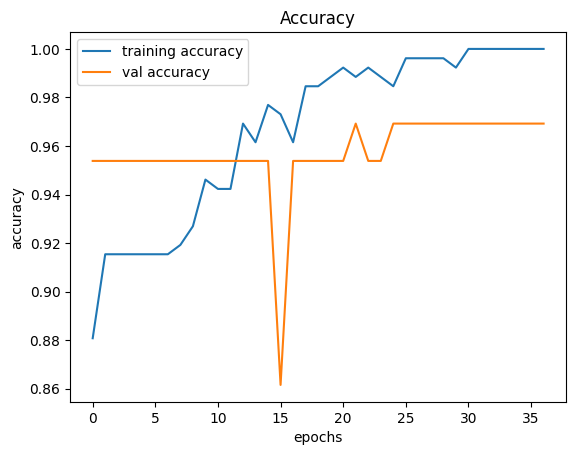

In [32]:
# Plotting graph for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

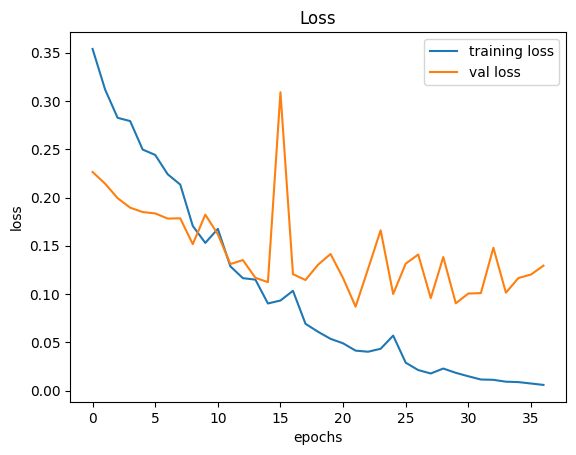

In [33]:
# Plotting graph for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [34]:
pred = model.predict(X_test)
X_preds = []
Y_preds = []
for i in range(20):
    score = tf.nn.softmax(pred[i])
    score = np.argmax(score)
    X_preds.append(score)
    y = np.argmax(y_test[i])
    Y_preds.append(y)
print(X_preds)
print(Y_preds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
[np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
[np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


In [35]:
total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(pred)):
    if np.argmax(pred[i]) == np.argmax(y_test[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)     
    total += 1
    
print('Total-test-data;', total, '\naccurately-predicted-data:', accurate, '\nwrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 65 
accurately-predicted-data: 63 
wrongly-predicted-data:  2
Accuracy: 96.923 %


## MODEL B

In [36]:
# Building the Model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(HEIGHT, WIDTH, CHANNEL)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,869,410 (49.09 MB)

 Trainable params: 12,869,410 (49.09 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
opt = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
loss = keras.losses.BinaryCrossentropy(from_logits=True)

# Compiling the model
model.compile(
    loss=loss, 
    optimizer=opt, 
    metrics=['accuracy'])

In [38]:
monitor_val_acc = EarlyStopping(monitor = 'val_loss', patience = 15)
checkpoint = ModelCheckpoint('my_model-SGD.h5', 
                             verbose=1, 
                             save_best_only=True)


history = model.fit(X_train, y_train, batch_size=50, epochs=100, validation_data=(X_test, y_test), 
                    callbacks=[checkpoint, monitor_val_acc])
#model.save('my_model-SGD.h5')

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.1828 - loss: 0.7726
Epoch 1: val_loss improved from inf to 0.65527, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 566ms/step - accuracy: 0.1962 - loss: 0.7698 - val_accuracy: 0.9385 - val_loss: 0.6553
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8078 - loss: 0.6394
Epoch 2: val_loss improved from 0.65527 to 0.46594, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - accuracy: 0.8116 - loss: 0.6361 - val_accuracy: 0.9538 - val_loss: 0.4659
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9337 - loss: 0.4740
Epoch 3: val_loss improved from 0.46594 to 0.34825, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step - accuracy: 0.9311 - loss: 0.4725 - val_accuracy: 0.9538 - val_loss: 0.3483
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9291 - loss: 0.3820
Epoch 4: val_loss improved from 0.34825 to 0.28672, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - accuracy: 0.9272 - loss: 0.3817 - val_accuracy: 0.9538 - val_loss: 0.2867
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.9137 - loss: 0.3386
Epoch 5: val_loss improved from 0.28672 to 0.25729, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 467ms/step - accuracy: 0.9139 - loss: 0.3385 - val_accuracy: 0.9538 - val_loss: 0.2573
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8763 - loss: 0.3923
Epoch 6: val_loss improved from 0.25729 to 0.24521, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 438ms/step - accuracy: 0.8819 - loss: 0.3812 - val_accuracy: 0.9538 - val_loss: 0.2452
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9305 - loss: 0.2691
Epoch 7: val_loss improved from 0.24521 to 0.23849, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 449ms/step - accuracy: 0.9283 - loss: 0.2748 - val_accuracy: 0.9538 - val_loss: 0.2385
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.9125 - loss: 0.3293
Epoch 8: val_loss improved from 0.23849 to 0.23566, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 426ms/step - accuracy: 0.9129 - loss: 0.3271 - val_accuracy: 0.9538 - val_loss: 0.2357
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9233 - loss: 0.2945
Epoch 9: val_loss improved from 0.23566 to 0.23414, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 441ms/step - accuracy: 0.9222 - loss: 0.2974 - val_accuracy: 0.9538 - val_loss: 0.2341
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9192 - loss: 0.3000
Epoch 10: val_loss improved from 0.23414 to 0.23348, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 425ms/step - accuracy: 0.9187 - loss: 0.3016 - val_accuracy: 0.9538 - val_loss: 0.2335
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8857 - loss: 0.3928
Epoch 11: val_loss did not improve from 0.23348
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 359ms/step - accuracy: 0.8899 - loss: 0.3809 - val_accuracy: 0.9538 - val_loss: 0.2336
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9191 - loss: 0.2927
Epoch 12: val_loss improved from 0.23348 to 0.23308, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 416ms/step - accuracy: 0.9186 - loss: 0.2946 - val_accuracy: 0.9538 - val_loss: 0.2331
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9040 - loss: 0.3419
Epoch 13: val_loss improved from 0.23308 to 0.23288, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - accuracy: 0.9056 - loss: 0.3378 - val_accuracy: 0.9538 - val_loss: 0.2329
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.9093 - loss: 0.3152
Epoch 14: val_loss improved from 0.23288 to 0.23218, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 449ms/step - accuracy: 0.9102 - loss: 0.3146 - val_accuracy: 0.9538 - val_loss: 0.2322
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9146 - loss: 0.3089
Epoch 15: val_loss improved from 0.23218 to 0.23168, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 452ms/step - accuracy: 0.9147 - loss: 0.3083 - val_accuracy: 0.9538 - val_loss: 0.2317
Epoch 16/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9243 - loss: 0.2818
Epoch 16: val_loss did not improve from 0.23168
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 383ms/step - accuracy: 0.9230 - loss: 0.2856 - val_accuracy: 0.9538 - val_loss: 0.2320
Epoch 17/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9243 - loss: 0.2846
Epoch 17: val_loss did not improve from 0.23168
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 398ms/step - accuracy: 0.9230 - loss: 0.2872 - val_accuracy: 0.9538 - val_loss: 0.2318
Epoch 18/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8960 - loss: 0.3510
Epoch 18: val_loss improved from 0.23168 to 0.23137, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step - accuracy: 0.8987 - loss: 0.3439 - val_accuracy: 0.9538 - val_loss: 0.2314
Epoch 19/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9166 - loss: 0.3136
Epoch 19: val_loss improved from 0.23137 to 0.23060, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 444ms/step - accuracy: 0.9164 - loss: 0.3133 - val_accuracy: 0.9538 - val_loss: 0.2306
Epoch 20/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9093 - loss: 0.3183
Epoch 20: val_loss improved from 0.23060 to 0.23012, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 426ms/step - accuracy: 0.9102 - loss: 0.3167 - val_accuracy: 0.9538 - val_loss: 0.2301
Epoch 21/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.9126 - loss: 0.3189
Epoch 21: val_loss improved from 0.23012 to 0.22955, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 476ms/step - accuracy: 0.9130 - loss: 0.3172 - val_accuracy: 0.9538 - val_loss: 0.2296
Epoch 22/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.9096 - loss: 0.3165
Epoch 22: val_loss improved from 0.22955 to 0.22889, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 443ms/step - accuracy: 0.9104 - loss: 0.3143 - val_accuracy: 0.9538 - val_loss: 0.2289
Epoch 23/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.8976 - loss: 0.3459
Epoch 23: val_loss improved from 0.22889 to 0.22831, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 449ms/step - accuracy: 0.9002 - loss: 0.3395 - val_accuracy: 0.9538 - val_loss: 0.2283
Epoch 24/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8929 - loss: 0.3614
Epoch 24: val_loss improved from 0.22831 to 0.22777, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 474ms/step - accuracy: 0.8961 - loss: 0.3527 - val_accuracy: 0.9538 - val_loss: 0.2278
Epoch 25/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9135 - loss: 0.3059
Epoch 25: val_loss improved from 0.22777 to 0.22717, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 478ms/step - accuracy: 0.9137 - loss: 0.3059 - val_accuracy: 0.9538 - val_loss: 0.2272
Epoch 26/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9298 - loss: 0.2663
Epoch 26: val_loss improved from 0.22717 to 0.22663, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 506ms/step - accuracy: 0.9278 - loss: 0.2718 - val_accuracy: 0.9538 - val_loss: 0.2266
Epoch 27/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9153 - loss: 0.3058
Epoch 27: val_loss improved from 0.22663 to 0.22630, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 489ms/step - accuracy: 0.9153 - loss: 0.3058 - val_accuracy: 0.9538 - val_loss: 0.2263
Epoch 28/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9176 - loss: 0.2985
Epoch 28: val_loss did not improve from 0.22630
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 422ms/step - accuracy: 0.9173 - loss: 0.2994 - val_accuracy: 0.9538 - val_loss: 0.2266
Epoch 29/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9161 - loss: 0.3013
Epoch 29: val_loss did not improve from 0.22630
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step - accuracy: 0.9160 - loss: 0.3010 - val_accuracy: 0.9538 - val_loss: 0.2267
Epoch 30/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.9034 - loss: 0.3209
Epoch 30: val_loss did not improve from 0.22630
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 430ms/step - accuracy: 0.9051 - loss: 0.3177 - val_accuracy: 0.9538 - val_loss: 0.2269
Epoch 31/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9115 - loss: 0.3146
Epoch 31: val_loss did not improve from 0.22630
6/6 

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - accuracy: 0.9073 - loss: 0.3259 - val_accuracy: 0.9538 - val_loss: 0.2257
Epoch 35/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9135 - loss: 0.3086
Epoch 35: val_loss improved from 0.22572 to 0.22493, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 409ms/step - accuracy: 0.9137 - loss: 0.3078 - val_accuracy: 0.9538 - val_loss: 0.2249
Epoch 36/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9140 - loss: 0.2999
Epoch 36: val_loss improved from 0.22493 to 0.22430, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 485ms/step - accuracy: 0.9142 - loss: 0.2999 - val_accuracy: 0.9538 - val_loss: 0.2243
Epoch 37/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9080 - loss: 0.3129
Epoch 37: val_loss improved from 0.22430 to 0.22380, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - accuracy: 0.9091 - loss: 0.3108 - val_accuracy: 0.9538 - val_loss: 0.2238
Epoch 38/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9246 - loss: 0.2751
Epoch 38: val_loss improved from 0.22380 to 0.22350, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 464ms/step - accuracy: 0.9233 - loss: 0.2787 - val_accuracy: 0.9538 - val_loss: 0.2235
Epoch 39/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9003 - loss: 0.3335
Epoch 39: val_loss improved from 0.22350 to 0.22337, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - accuracy: 0.9025 - loss: 0.3284 - val_accuracy: 0.9538 - val_loss: 0.2234
Epoch 40/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9080 - loss: 0.3148
Epoch 40: val_loss did not improve from 0.22337
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 375ms/step - accuracy: 0.9091 - loss: 0.3121 - val_accuracy: 0.9538 - val_loss: 0.2238
Epoch 41/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9140 - loss: 0.3034
Epoch 41: val_loss did not improve from 0.22337
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - accuracy: 0.9142 - loss: 0.3024 - val_accuracy: 0.9538 - val_loss: 0.2240
Epoch 42/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.9154 - loss: 0.3032
Epoch 42: val_loss did not improve from 0.22337
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step - accuracy: 0.9154 - loss: 0.3028 - val_accuracy: 0.9538 - val_loss: 0.2236
Epoch 43/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9193 - loss: 0.2846
Epoch 43: val_loss improved from 0.22337 to 0.22295,

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 426ms/step - accuracy: 0.9187 - loss: 0.2865 - val_accuracy: 0.9538 - val_loss: 0.2229
Epoch 44/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9379 - loss: 0.2415
Epoch 44: val_loss improved from 0.22295 to 0.22215, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 460ms/step - accuracy: 0.9347 - loss: 0.2494 - val_accuracy: 0.9538 - val_loss: 0.2222
Epoch 45/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.9186 - loss: 0.2933
Epoch 45: val_loss improved from 0.22215 to 0.22167, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 440ms/step - accuracy: 0.9181 - loss: 0.2938 - val_accuracy: 0.9538 - val_loss: 0.2217
Epoch 46/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9022 - loss: 0.3276
Epoch 46: val_loss did not improve from 0.22167
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 364ms/step - accuracy: 0.9041 - loss: 0.3230 - val_accuracy: 0.9538 - val_loss: 0.2217
Epoch 47/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9198 - loss: 0.2799
Epoch 47: val_loss did not improve from 0.22167
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 374ms/step - accuracy: 0.9192 - loss: 0.2815 - val_accuracy: 0.9538 - val_loss: 0.2217
Epoch 48/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9131 - loss: 0.2999
Epoch 48: val_loss did not improve from 0.22167
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 358ms/step - accuracy: 0.9134 - loss: 0.2989 - val_accuracy: 0.9538 - val_loss: 0.2220
Epoch 49/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9077 - loss: 0.3130
Epoch 49: val_loss did not improve from 0.22167
6/6 

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 388ms/step - accuracy: 0.9113 - loss: 0.3030 - val_accuracy: 0.9538 - val_loss: 0.2214
Epoch 53/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.9137 - loss: 0.2925
Epoch 53: val_loss improved from 0.22143 to 0.22040, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 403ms/step - accuracy: 0.9140 - loss: 0.2927 - val_accuracy: 0.9538 - val_loss: 0.2204
Epoch 54/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9255 - loss: 0.2693
Epoch 54: val_loss improved from 0.22040 to 0.21942, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step - accuracy: 0.9241 - loss: 0.2726 - val_accuracy: 0.9538 - val_loss: 0.2194
Epoch 55/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9288 - loss: 0.2729
Epoch 55: val_loss improved from 0.21942 to 0.21906, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step - accuracy: 0.9269 - loss: 0.2763 - val_accuracy: 0.9538 - val_loss: 0.2191
Epoch 56/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9295 - loss: 0.2550
Epoch 56: val_loss improved from 0.21906 to 0.21906, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 468ms/step - accuracy: 0.9275 - loss: 0.2599 - val_accuracy: 0.9538 - val_loss: 0.2191
Epoch 57/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9295 - loss: 0.2610
Epoch 57: val_loss did not improve from 0.21906
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 388ms/step - accuracy: 0.9275 - loss: 0.2658 - val_accuracy: 0.9538 - val_loss: 0.2198
Epoch 58/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9196 - loss: 0.2813
Epoch 58: val_loss did not improve from 0.21906
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 413ms/step - accuracy: 0.9190 - loss: 0.2827 - val_accuracy: 0.9538 - val_loss: 0.2207
Epoch 59/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9044 - loss: 0.3154
Epoch 59: val_loss did not improve from 0.21906
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 422ms/step - accuracy: 0.9060 - loss: 0.3124 - val_accuracy: 0.9538 - val_loss: 0.2206
Epoch 60/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9090 - loss: 0.3084
Epoch 60: val_loss did not improve from 0.21906
6/6 

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 458ms/step - accuracy: 0.9212 - loss: 0.2774 - val_accuracy: 0.9538 - val_loss: 0.2190
Epoch 62/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9242 - loss: 0.2709
Epoch 62: val_loss improved from 0.21901 to 0.21823, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 445ms/step - accuracy: 0.9230 - loss: 0.2741 - val_accuracy: 0.9538 - val_loss: 0.2182
Epoch 63/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9190 - loss: 0.2803
Epoch 63: val_loss did not improve from 0.21823
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 420ms/step - accuracy: 0.9185 - loss: 0.2816 - val_accuracy: 0.9538 - val_loss: 0.2184
Epoch 64/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.9113 - loss: 0.2997
Epoch 64: val_loss improved from 0.21823 to 0.21786, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 449ms/step - accuracy: 0.9119 - loss: 0.2982 - val_accuracy: 0.9538 - val_loss: 0.2179
Epoch 65/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.9315 - loss: 0.2528
Epoch 65: val_loss improved from 0.21786 to 0.21732, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 445ms/step - accuracy: 0.9292 - loss: 0.2576 - val_accuracy: 0.9538 - val_loss: 0.2173
Epoch 66/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9190 - loss: 0.2812
Epoch 66: val_loss did not improve from 0.21732
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 407ms/step - accuracy: 0.9184 - loss: 0.2822 - val_accuracy: 0.9538 - val_loss: 0.2176
Epoch 67/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9040 - loss: 0.3148
Epoch 67: val_loss did not improve from 0.21732
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 359ms/step - accuracy: 0.9056 - loss: 0.3114 - val_accuracy: 0.9538 - val_loss: 0.2184
Epoch 68/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9071 - loss: 0.3082
Epoch 68: val_loss did not improve from 0.21732
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 406ms/step - accuracy: 0.9083 - loss: 0.3052 - val_accuracy: 0.9538 - val_loss: 0.2178
Epoch 69/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9313 - loss: 0.2611
Epoch 69: val_loss improved from 0.21732 to 0.21636,

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 542ms/step - accuracy: 0.9291 - loss: 0.2652 - val_accuracy: 0.9538 - val_loss: 0.2164
Epoch 70/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9218 - loss: 0.2832
Epoch 70: val_loss improved from 0.21636 to 0.21589, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 547ms/step - accuracy: 0.9209 - loss: 0.2838 - val_accuracy: 0.9538 - val_loss: 0.2159
Epoch 71/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9180 - loss: 0.2826
Epoch 71: val_loss did not improve from 0.21589
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 481ms/step - accuracy: 0.9176 - loss: 0.2837 - val_accuracy: 0.9538 - val_loss: 0.2166
Epoch 72/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9290 - loss: 0.2542
Epoch 72: val_loss did not improve from 0.21589
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 449ms/step - accuracy: 0.9270 - loss: 0.2584 - val_accuracy: 0.9538 - val_loss: 0.2167
Epoch 73/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.9146 - loss: 0.2919
Epoch 73: val_loss did not improve from 0.21589
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step - accuracy: 0.9147 - loss: 0.2908 - val_accuracy: 0.9538 - val_loss: 0.2173
Epoch 74/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.9208 - loss: 0.2774
Epoch 74: val_loss did not improve from 0.21589
6/6 

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 436ms/step - accuracy: 0.9200 - loss: 0.2716 - val_accuracy: 0.9538 - val_loss: 0.2148
Epoch 80/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9236 - loss: 0.2656
Epoch 80: val_loss improved from 0.21479 to 0.21388, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 438ms/step - accuracy: 0.9224 - loss: 0.2678 - val_accuracy: 0.9538 - val_loss: 0.2139
Epoch 81/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.9054 - loss: 0.3086
Epoch 81: val_loss improved from 0.21388 to 0.21319, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 444ms/step - accuracy: 0.9068 - loss: 0.3053 - val_accuracy: 0.9538 - val_loss: 0.2132
Epoch 82/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.9244 - loss: 0.2677
Epoch 82: val_loss improved from 0.21319 to 0.21202, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 448ms/step - accuracy: 0.9231 - loss: 0.2697 - val_accuracy: 0.9538 - val_loss: 0.2120
Epoch 83/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.9029 - loss: 0.3156
Epoch 83: val_loss improved from 0.21202 to 0.21135, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step - accuracy: 0.9047 - loss: 0.3112 - val_accuracy: 0.9538 - val_loss: 0.2114
Epoch 84/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9238 - loss: 0.2586
Epoch 84: val_loss improved from 0.21135 to 0.21044, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step - accuracy: 0.9226 - loss: 0.2608 - val_accuracy: 0.9538 - val_loss: 0.2104
Epoch 85/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9219 - loss: 0.2622
Epoch 85: val_loss improved from 0.21044 to 0.20999, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - accuracy: 0.9210 - loss: 0.2644 - val_accuracy: 0.9538 - val_loss: 0.2100
Epoch 86/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9129 - loss: 0.2961
Epoch 86: val_loss improved from 0.20999 to 0.20984, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 417ms/step - accuracy: 0.9133 - loss: 0.2940 - val_accuracy: 0.9538 - val_loss: 0.2098
Epoch 87/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9238 - loss: 0.2626
Epoch 87: val_loss improved from 0.20984 to 0.20941, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 424ms/step - accuracy: 0.9226 - loss: 0.2654 - val_accuracy: 0.9538 - val_loss: 0.2094
Epoch 88/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.8960 - loss: 0.3131
Epoch 88: val_loss improved from 0.20941 to 0.20935, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - accuracy: 0.8987 - loss: 0.3084 - val_accuracy: 0.9538 - val_loss: 0.2094
Epoch 89/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9127 - loss: 0.2917
Epoch 89: val_loss improved from 0.20935 to 0.20904, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 477ms/step - accuracy: 0.9131 - loss: 0.2900 - val_accuracy: 0.9538 - val_loss: 0.2090
Epoch 90/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.9126 - loss: 0.2978
Epoch 90: val_loss did not improve from 0.20904
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 372ms/step - accuracy: 0.9130 - loss: 0.2959 - val_accuracy: 0.9538 - val_loss: 0.2096
Epoch 91/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.8943 - loss: 0.3243
Epoch 91: val_loss did not improve from 0.20904
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 428ms/step - accuracy: 0.8973 - loss: 0.3185 - val_accuracy: 0.9538 - val_loss: 0.2096
Epoch 92/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9210 - loss: 0.2624
Epoch 92: val_loss improved from 0.20904 to 0.20868, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 436ms/step - accuracy: 0.9202 - loss: 0.2643 - val_accuracy: 0.9538 - val_loss: 0.2087
Epoch 93/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.9409 - loss: 0.2167
Epoch 93: val_loss improved from 0.20868 to 0.20753, saving model to my_model-SGD.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 448ms/step - accuracy: 0.9373 - loss: 0.2254 - val_accuracy: 0.9538 - val_loss: 0.2075
Epoch 94/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9061 - loss: 0.2967
Epoch 94: val_loss did not improve from 0.20753
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step - accuracy: 0.9074 - loss: 0.2938 - val_accuracy: 0.9538 - val_loss: 0.2076
Epoch 95/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9199 - loss: 0.2721
Epoch 95: val_loss did not improve from 0.20753
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step - accuracy: 0.9193 - loss: 0.2734 - val_accuracy: 0.9538 - val_loss: 0.2076
Epoch 96/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.9288 - loss: 0.2508
Epoch 96: val_loss did not improve from 0.20753
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step - accuracy: 0.9269 - loss: 0.2542 - val_accuracy: 0.9538 - val_loss: 0.2086
Epoch 97/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.9300 - loss: 0.2446
Epoch 97: val_loss did not improve from 0.20753
6/6 

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 443ms/step - accuracy: 0.9299 - loss: 0.2507 - val_accuracy: 0.9538 - val_loss: 0.2063


In [39]:
model.evaluate(X_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9574 - loss: 0.1943


[0.20627440512180328, 0.9538461565971375]

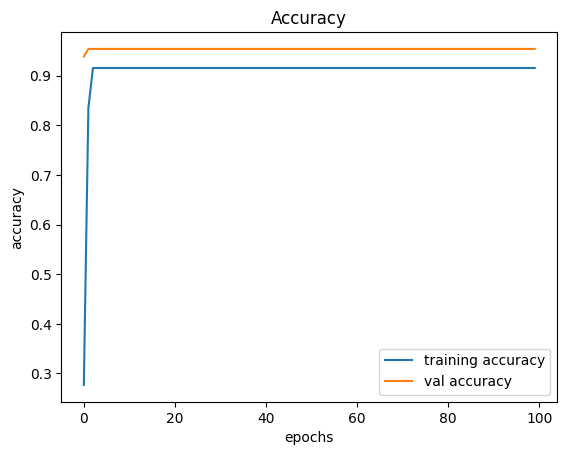

In [40]:
# Plotting graph for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

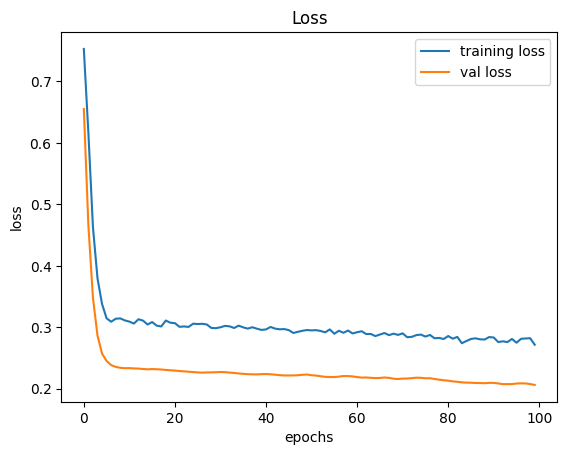

In [41]:
# Plotting graph for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [42]:
pred = model.predict(X_test)
X_preds = []
Y_preds = []
for i in range(30):
    score = tf.nn.softmax(pred[i])
    score = np.argmax(score)
    X_preds.append(score)
    y = np.argmax(y_test[i])
    Y_preds.append(y)
print('X_preds:', X_preds)
print('Y_preds:', Y_preds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
X_preds: [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
Y_preds: [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


In [43]:
total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(pred)):
    if np.argmax(pred[i]) == np.argmax(y_test[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)     
    total += 1
    
print('Total-test-data;', total, '\naccurately-predicted-data:', accurate, '\nwrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 65 
accurately-predicted-data: 62 
wrongly-predicted-data:  3
Accuracy: 95.385 %


# PRE-TRAINED MODELS

## MODEL C - NASNETMOBILE

In [44]:
model_d = NASNetMobile(weights='imagenet', include_top=False, 
                       input_shape=(WIDTH, HEIGHT, CHANNEL)) 
x = model_d.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x) 
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
preds = Dense(2, activation='softmax')(x)

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [45]:
# building the model
model = Model(inputs=model_d.input, outputs=preds)
model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 111, 111,  │        128 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 111, 111,  │        352 │ activation[0][0]  │
│ (Conv2D)            │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 111, 111,  │         44 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 111, 111,  │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 115, 115,  │          0 │ activation_1[0][… │
│ (ZeroPadding2D)     │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 117, 117,  │          0 │ activation_3[0][… │
│ (ZeroPadding2D)     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │        396 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │      1,920 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 56, 56,    │        396 │ activation_2[0][

 Total params: 4,818,198 (18.38 MB)

 Trainable params: 4,778,324 (18.23 MB)

 Non-trainable params: 39,874 (155.76 KB)

In [46]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [47]:
redlr = ReduceLROnPlateau(monitor='val_accuracy', 
                          factor=0.5,
                          patience=3, 
                          verbose=1, 
                          min_lr=1e-2)

checkpoint = ModelCheckpoint('model-nasnet.h5', 
                             verbose=1, 
                             save_best_only=True)
monitor_val_acc = EarlyStopping(monitor = 'val_loss', patience = 15)

In [48]:
opt = Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.999, epsilon=1e-08)
loss = keras.losses.BinaryCrossentropy(from_logits=True)

# Compiling the model
model.compile(
    loss=loss, 
    optimizer=opt, 
    metrics=['accuracy'])

In [49]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range = 0.2, 
                             horizontal_flip=True, 
                             shear_range=0.2,
                             vertical_flip=True,
                             rotation_range=10,
                             fill_mode="nearest")
datagen.fit(X_train)
# Training the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=50), 
                    epochs=100, 
                    callbacks=[redlr, checkpoint, monitor_val_acc], 
                    validation_data=(X_test, y_test))

/root/covid-classification/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4979 - loss: 1.0164 
Epoch 1: val_loss improved from inf to 0.70330, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.4993 - loss: 1.0155 - val_accuracy: 0.4769 - val_loss: 0.7033 - learning_rate: 1.0000e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5623 - loss: 1.0237
Epoch 2: val_loss improved from 0.70330 to 0.69173, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5655 - loss: 1.0133 - val_accuracy: 0.5846 - val_loss: 0.6917 - learning_rate: 1.0000e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6078 - loss: 0.8697
Epoch 3: val_loss improved from 0.69173 to 0.67299, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6083 - loss: 0.8667 - val_accuracy: 0.6308 - val_loss: 0.6730 - learning_rate: 1.0000e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5626 - loss: 0.9396  
Epoch 4: val_loss improved from 0.67299 to 0.66783, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5641 - loss: 0.9355 - val_accuracy: 0.6769 - val_loss: 0.6678 - learning_rate: 1.0000e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6418 - loss: 0.9009
Epoch 5: val_loss did not improve from 0.66783
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.6407 - loss: 0.9012 - val_accuracy: 0.6462 - val_loss: 0.6713 - learning_rate: 1.0000e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5443 - loss: 0.9440
Epoch 6: val_loss did not improve from 0.66783
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5462 - loss: 0.9419 - val_accuracy: 0.5846 - val_loss: 0.6824 - learning_rate: 1.0000e-04
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5798 - loss: 0.8987
Epoch 7: val_loss did not improve from 0.66783
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5848 - loss: 0.8955 - val_accuracy: 0.6154 - val_loss: 0.6805 - learning_rate: 1.0000e-04
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step 

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6405 - loss: 0.7976 - val_accuracy: 0.6769 - val_loss: 0.6676 - learning_rate: 1.0000e-04
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6449 - loss: 0.8392  
Epoch 9: val_loss improved from 0.66759 to 0.64299, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6472 - loss: 0.8368 - val_accuracy: 0.7385 - val_loss: 0.6430 - learning_rate: 1.0000e-04
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6117 - loss: 0.9127
Epoch 10: val_loss did not improve from 0.64299
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6128 - loss: 0.9043 - val_accuracy: 0.7385 - val_loss: 0.6437 - learning_rate: 1.0000e-04
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6528 - loss: 0.8882   
Epoch 11: val_loss improved from 0.64299 to 0.63806, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.6552 - loss: 0.8814 - val_accuracy: 0.7385 - val_loss: 0.6381 - learning_rate: 1.0000e-04
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6735 - loss: 0.7379   
Epoch 12: val_loss did not improve from 0.63806
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6734 - loss: 0.7376 - val_accuracy: 0.7231 - val_loss: 0.6433 - learning_rate: 1.0000e-04
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7012 - loss: 0.7389
Epoch 13: val_loss improved from 0.63806 to 0.63532, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7005 - loss: 0.7392 - val_accuracy: 0.7538 - val_loss: 0.6353 - learning_rate: 1.0000e-04
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6317 - loss: 0.8093
Epoch 14: val_loss improved from 0.63532 to 0.63355, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6321 - loss: 0.8132 - val_accuracy: 0.7538 - val_loss: 0.6335 - learning_rate: 1.0000e-04
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6366 - loss: 0.8183
Epoch 15: val_loss improved from 0.63355 to 0.62858, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.6385 - loss: 0.8136 - val_accuracy: 0.7538 - val_loss: 0.6286 - learning_rate: 1.0000e-04
Epoch 16/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6569 - loss: 0.6947  
Epoch 16: val_loss improved from 0.62858 to 0.61569, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.6510 - loss: 0.7120 - val_accuracy: 0.7846 - val_loss: 0.6157 - learning_rate: 1.0000e-04
Epoch 17/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7135 - loss: 0.7450
Epoch 17: val_loss improved from 0.61569 to 0.61430, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7159 - loss: 0.7381 - val_accuracy: 0.8154 - val_loss: 0.6143 - learning_rate: 1.0000e-04
Epoch 18/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6678 - loss: 0.7074
Epoch 18: val_loss did not improve from 0.61430
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6696 - loss: 0.7083 - val_accuracy: 0.7846 - val_loss: 0.6167 - learning_rate: 1.0000e-04
Epoch 19/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7110 - loss: 0.6525
Epoch 19: val_loss did not improve from 0.61430
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7045 - loss: 0.6617 - val_accuracy: 0.7538 - val_loss: 0.6244 - learning_rate: 1.0000e-04
Epoch 20/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7342 - loss: 0.7019
Epoch 20: val_loss improved from 0.61430 to 0.60482, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7293 - loss: 0.7047 - val_accuracy: 0.7846 - val_loss: 0.6048 - learning_rate: 1.0000e-04
Epoch 21/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6745 - loss: 0.7166
Epoch 21: val_loss improved from 0.60482 to 0.58852, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.6787 - loss: 0.7124 - val_accuracy: 0.8308 - val_loss: 0.5885 - learning_rate: 1.0000e-04
Epoch 22/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6476 - loss: 0.7638
Epoch 22: val_loss did not improve from 0.58852
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6496 - loss: 0.7602 - val_accuracy: 0.8308 - val_loss: 0.5894 - learning_rate: 1.0000e-04
Epoch 23/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6702 - loss: 0.6812 
Epoch 23: val_loss improved from 0.58852 to 0.57698, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6717 - loss: 0.6847 - val_accuracy: 0.8462 - val_loss: 0.5770 - learning_rate: 1.0000e-04
Epoch 24/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6805 - loss: 0.7013
Epoch 24: val_loss did not improve from 0.57698
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.6811 - loss: 0.7005 - val_accuracy: 0.8462 - val_loss: 0.5781 - learning_rate: 1.0000e-04
Epoch 25/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7142 - loss: 0.6924
Epoch 25: val_loss improved from 0.57698 to 0.56814, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7083 - loss: 0.6993 - val_accuracy: 0.8462 - val_loss: 0.5681 - learning_rate: 1.0000e-04
Epoch 26/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7580 - loss: 0.6106
Epoch 26: val_loss did not improve from 0.56814
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7535 - loss: 0.6214 - val_accuracy: 0.8462 - val_loss: 0.5723 - learning_rate: 1.0000e-04
Epoch 27/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6964 - loss: 0.7371 
Epoch 27: val_loss improved from 0.56814 to 0.56487, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7008 - loss: 0.7254 - val_accuracy: 0.8615 - val_loss: 0.5649 - learning_rate: 1.0000e-04
Epoch 28/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7625 - loss: 0.6775
Epoch 28: val_loss did not improve from 0.56487
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7607 - loss: 0.6728 - val_accuracy: 0.8308 - val_loss: 0.5664 - learning_rate: 1.0000e-04
Epoch 29/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7136 - loss: 0.6239
Epoch 29: val_loss improved from 0.56487 to 0.56159, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7172 - loss: 0.6244 - val_accuracy: 0.8615 - val_loss: 0.5616 - learning_rate: 1.0000e-04
Epoch 30/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6959 - loss: 0.7210
Epoch 30: val_loss improved from 0.56159 to 0.55802, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6997 - loss: 0.7111 - val_accuracy: 0.8462 - val_loss: 0.5580 - learning_rate: 1.0000e-04
Epoch 31/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7412 - loss: 0.6215
Epoch 31: val_loss improved from 0.55802 to 0.54795, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7402 - loss: 0.6238 - val_accuracy: 0.8462 - val_loss: 0.5480 - learning_rate: 1.0000e-04
Epoch 32/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6555 - loss: 0.6758
Epoch 32: val_loss improved from 0.54795 to 0.54105, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6635 - loss: 0.6698 - val_accuracy: 0.8462 - val_loss: 0.5410 - learning_rate: 1.0000e-04
Epoch 33/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7245 - loss: 0.6555 
Epoch 33: val_loss improved from 0.54105 to 0.53948, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7276 - loss: 0.6504 - val_accuracy: 0.8462 - val_loss: 0.5395 - learning_rate: 1.0000e-04
Epoch 34/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7410 - loss: 0.6767  
Epoch 34: val_loss did not improve from 0.53948
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7434 - loss: 0.6706 - val_accuracy: 0.8308 - val_loss: 0.5404 - learning_rate: 1.0000e-04
Epoch 35/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7627 - loss: 0.5754  
Epoch 35: val_loss improved from 0.53948 to 0.52879, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7598 - loss: 0.5783 - val_accuracy: 0.8462 - val_loss: 0.5288 - learning_rate: 1.0000e-04
Epoch 36/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6975 - loss: 0.7113  
Epoch 36: val_loss improved from 0.52879 to 0.52271, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7034 - loss: 0.6971 - val_accuracy: 0.8615 - val_loss: 0.5227 - learning_rate: 1.0000e-04
Epoch 37/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7772 - loss: 0.5714
Epoch 37: val_loss did not improve from 0.52271
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7777 - loss: 0.5716 - val_accuracy: 0.8462 - val_loss: 0.5235 - learning_rate: 1.0000e-04
Epoch 38/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7805 - loss: 0.6435 
Epoch 38: val_loss improved from 0.52271 to 0.51439, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7800 - loss: 0.6412 - val_accuracy: 0.8462 - val_loss: 0.5144 - learning_rate: 1.0000e-04
Epoch 39/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6938 - loss: 0.6973
Epoch 39: val_loss improved from 0.51439 to 0.50235, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7024 - loss: 0.6807 - val_accuracy: 0.8462 - val_loss: 0.5024 - learning_rate: 1.0000e-04
Epoch 40/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7563 - loss: 0.5854
Epoch 40: val_loss improved from 0.50235 to 0.49346, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7576 - loss: 0.5826 - val_accuracy: 0.8462 - val_loss: 0.4935 - learning_rate: 1.0000e-04
Epoch 41/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8397 - loss: 0.4580 
Epoch 41: val_loss did not improve from 0.49346
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8335 - loss: 0.4659 - val_accuracy: 0.8462 - val_loss: 0.5049 - learning_rate: 1.0000e-04
Epoch 42/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8482 - loss: 0.4882
Epoch 42: val_loss did not improve from 0.49346
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8446 - loss: 0.4934 - val_accuracy: 0.8462 - val_loss: 0.4977 - learning_rate: 1.0000e-04
Epoch 43/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7709 - loss: 0.6014 
Epoch 43: val_loss did not improve from 0.49346
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7734 - loss: 0.5955 - val_accuracy: 0.8615 - val_loss: 0.4964 - learning_rate: 1.0000e-04
Epoch 44/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2

6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7540 - loss: 0.6139 - val_accuracy: 0.8615 - val_loss: 0.4893 - learning_rate: 1.0000e-04
Epoch 45/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7971 - loss: 0.5801
Epoch 45: val_loss improved from 0.48927 to 0.48812, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7997 - loss: 0.5783 - val_accuracy: 0.8462 - val_loss: 0.4881 - learning_rate: 1.0000e-04
Epoch 46/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8121 - loss: 0.5515
Epoch 46: val_loss improved from 0.48812 to 0.48498, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8098 - loss: 0.5491 - val_accuracy: 0.8308 - val_loss: 0.4850 - learning_rate: 1.0000e-04
Epoch 47/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - accuracy: 0.8458 - loss: 0.5107
Epoch 47: val_loss improved from 0.48498 to 0.47723, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8420 - loss: 0.5140 - val_accuracy: 0.8769 - val_loss: 0.4772 - learning_rate: 1.0000e-04
Epoch 48/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8498 - loss: 0.4596
Epoch 48: val_loss did not improve from 0.47723
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8471 - loss: 0.4646 - val_accuracy: 0.8769 - val_loss: 0.4777 - learning_rate: 1.0000e-04
Epoch 49/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8403 - loss: 0.5198 
Epoch 49: val_loss did not improve from 0.47723
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8384 - loss: 0.5216 - val_accuracy: 0.8769 - val_loss: 0.4776 - learning_rate: 1.0000e-04
Epoch 50/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 0.8042 - loss: 0.5077
Epoch 50: val_loss improved from 0.47723 to 0.47552, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8025 - loss: 0.5070 - val_accuracy: 0.8769 - val_loss: 0.4755 - learning_rate: 1.0000e-04
Epoch 51/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8333 - loss: 0.4419   
Epoch 51: val_loss improved from 0.47552 to 0.46130, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8324 - loss: 0.4470 - val_accuracy: 0.8462 - val_loss: 0.4613 - learning_rate: 1.0000e-04
Epoch 52/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7825 - loss: 0.5979   
Epoch 52: val_loss did not improve from 0.46130
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7872 - loss: 0.5900 - val_accuracy: 0.8769 - val_loss: 0.4650 - learning_rate: 1.0000e-04
Epoch 53/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - accuracy: 0.8077 - loss: 0.5262
Epoch 53: val_loss did not improve from 0.46130
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8055 - loss: 0.5294 - val_accuracy: 0.8769 - val_loss: 0.4627 - learning_rate: 1.0000e-04
Epoch 54/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.8215 - loss: 0.4794
Epoch 54: val_loss did not improve from 0.46130
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8217 - loss: 0.4813 - val_accuracy: 0.8923 - val_loss: 0.4656 - learning_rate: 1.0000e-04
Epoch 55/100
6/6 ━━━━━━━━━━━━━━━━━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8569 - loss: 0.4602 - val_accuracy: 0.8615 - val_loss: 0.4486 - learning_rate: 1.0000e-04
Epoch 57/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - accuracy: 0.8250 - loss: 0.4847
Epoch 57: val_loss did not improve from 0.44861
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8225 - loss: 0.4866 - val_accuracy: 0.8615 - val_loss: 0.4539 - learning_rate: 1.0000e-04
Epoch 58/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8305 - loss: 0.5380
Epoch 58: val_loss improved from 0.44861 to 0.43888, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8300 - loss: 0.5331 - val_accuracy: 0.8769 - val_loss: 0.4389 - learning_rate: 1.0000e-04
Epoch 59/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8369 - loss: 0.4856   
Epoch 59: val_loss improved from 0.43888 to 0.43798, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8376 - loss: 0.4876 - val_accuracy: 0.8769 - val_loss: 0.4380 - learning_rate: 1.0000e-04
Epoch 60/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8399 - loss: 0.4914   
Epoch 60: val_loss improved from 0.43798 to 0.43367, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8380 - loss: 0.4915 - val_accuracy: 0.8923 - val_loss: 0.4337 - learning_rate: 1.0000e-04
Epoch 61/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8499 - loss: 0.4499  
Epoch 61: val_loss improved from 0.43367 to 0.42435, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8504 - loss: 0.4575 - val_accuracy: 0.8462 - val_loss: 0.4244 - learning_rate: 1.0000e-04
Epoch 62/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1000ms/step - accuracy: 0.8501 - loss: 0.4529
Epoch 62: val_loss improved from 0.42435 to 0.41485, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8512 - loss: 0.4555 - val_accuracy: 0.8462 - val_loss: 0.4149 - learning_rate: 1.0000e-04
Epoch 63/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8490 - loss: 0.4558   
Epoch 63: val_loss did not improve from 0.41485
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8480 - loss: 0.4579 - val_accuracy: 0.8923 - val_loss: 0.4153 - learning_rate: 1.0000e-04
Epoch 64/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7977 - loss: 0.5666
Epoch 64: val_loss improved from 0.41485 to 0.40929, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8052 - loss: 0.5528 - val_accuracy: 0.8769 - val_loss: 0.4093 - learning_rate: 1.0000e-04
Epoch 65/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - accuracy: 0.8836 - loss: 0.4099
Epoch 65: val_loss did not improve from 0.40929
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8766 - loss: 0.4243 - val_accuracy: 0.8769 - val_loss: 0.4172 - learning_rate: 1.0000e-04
Epoch 66/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - accuracy: 0.8716 - loss: 0.4055
Epoch 66: val_loss did not improve from 0.40929
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8685 - loss: 0.4122 - val_accuracy: 0.8923 - val_loss: 0.4179 - learning_rate: 1.0000e-04
Epoch 67/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8232 - loss: 0.5092
Epoch 67: val_loss did not improve from 0.40929
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8226 - loss: 0.5114 - val_accuracy: 0.8923 - val_loss: 0.4202 - learning_rate: 1.0000e-04
Epoch 68/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8581 - loss: 0.4183 - val_accuracy: 0.8923 - val_loss: 0.3996 - learning_rate: 1.0000e-04
Epoch 69/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8228 - loss: 0.4472
Epoch 69: val_loss improved from 0.39955 to 0.39847, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8294 - loss: 0.4425 - val_accuracy: 0.8923 - val_loss: 0.3985 - learning_rate: 1.0000e-04
Epoch 70/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8703 - loss: 0.3896  
Epoch 70: val_loss did not improve from 0.39847
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8674 - loss: 0.3944 - val_accuracy: 0.9077 - val_loss: 0.4101 - learning_rate: 1.0000e-04
Epoch 71/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8224 - loss: 0.4727   
Epoch 71: val_loss improved from 0.39847 to 0.39646, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8252 - loss: 0.4689 - val_accuracy: 0.8923 - val_loss: 0.3965 - learning_rate: 1.0000e-04
Epoch 72/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8478 - loss: 0.4342  
Epoch 72: val_loss improved from 0.39646 to 0.39079, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8437 - loss: 0.4415 - val_accuracy: 0.9077 - val_loss: 0.3908 - learning_rate: 1.0000e-04
Epoch 73/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8309 - loss: 0.4622  
Epoch 73: val_loss improved from 0.39079 to 0.38943, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8320 - loss: 0.4588 - val_accuracy: 0.8923 - val_loss: 0.3894 - learning_rate: 1.0000e-04
Epoch 74/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8134 - loss: 0.4529
Epoch 74: val_loss did not improve from 0.38943
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8219 - loss: 0.4449 - val_accuracy: 0.8923 - val_loss: 0.3920 - learning_rate: 1.0000e-04
Epoch 75/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7966 - loss: 0.5079
Epoch 75: val_loss improved from 0.38943 to 0.38438, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8015 - loss: 0.4986 - val_accuracy: 0.8923 - val_loss: 0.3844 - learning_rate: 1.0000e-04
Epoch 76/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.8438 - loss: 0.4093
Epoch 76: val_loss improved from 0.38438 to 0.37940, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8469 - loss: 0.4079 - val_accuracy: 0.8923 - val_loss: 0.3794 - learning_rate: 1.0000e-04
Epoch 77/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8110 - loss: 0.5369
Epoch 77: val_loss improved from 0.37940 to 0.37771, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8155 - loss: 0.5260 - val_accuracy: 0.8923 - val_loss: 0.3777 - learning_rate: 1.0000e-04
Epoch 78/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8444 - loss: 0.4847 
Epoch 78: val_loss improved from 0.37771 to 0.37688, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8491 - loss: 0.4746 - val_accuracy: 0.8923 - val_loss: 0.3769 - learning_rate: 1.0000e-04
Epoch 79/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8893 - loss: 0.3860
Epoch 79: val_loss improved from 0.37688 to 0.37303, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8864 - loss: 0.3951 - val_accuracy: 0.8923 - val_loss: 0.3730 - learning_rate: 1.0000e-04
Epoch 80/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8540 - loss: 0.4562 
Epoch 80: val_loss did not improve from 0.37303
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8562 - loss: 0.4492 - val_accuracy: 0.8923 - val_loss: 0.3748 - learning_rate: 1.0000e-04
Epoch 81/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8712 - loss: 0.4086
Epoch 81: val_loss improved from 0.37303 to 0.36539, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8720 - loss: 0.4074 - val_accuracy: 0.8923 - val_loss: 0.3654 - learning_rate: 1.0000e-04
Epoch 82/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8700 - loss: 0.4262   
Epoch 82: val_loss improved from 0.36539 to 0.36005, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8727 - loss: 0.4197 - val_accuracy: 0.9077 - val_loss: 0.3601 - learning_rate: 1.0000e-04
Epoch 83/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9035 - loss: 0.3860
Epoch 83: val_loss did not improve from 0.36005
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9057 - loss: 0.3826 - val_accuracy: 0.8923 - val_loss: 0.3653 - learning_rate: 1.0000e-04
Epoch 84/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9085 - loss: 0.3005 
Epoch 84: val_loss improved from 0.36005 to 0.35831, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9067 - loss: 0.3070 - val_accuracy: 0.8923 - val_loss: 0.3583 - learning_rate: 1.0000e-04
Epoch 85/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 0.8737 - loss: 0.4189
Epoch 85: val_loss improved from 0.35831 to 0.35121, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8753 - loss: 0.4164 - val_accuracy: 0.8923 - val_loss: 0.3512 - learning_rate: 1.0000e-04
Epoch 86/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8987 - loss: 0.3703  
Epoch 86: val_loss did not improve from 0.35121
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8967 - loss: 0.3730 - val_accuracy: 0.9077 - val_loss: 0.3564 - learning_rate: 1.0000e-04
Epoch 87/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8677 - loss: 0.3937
Epoch 87: val_loss improved from 0.35121 to 0.34878, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8690 - loss: 0.3902 - val_accuracy: 0.8923 - val_loss: 0.3488 - learning_rate: 1.0000e-04
Epoch 88/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.9062 - loss: 0.3607
Epoch 88: val_loss did not improve from 0.34878
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9070 - loss: 0.3576 - val_accuracy: 0.8923 - val_loss: 0.3558 - learning_rate: 1.0000e-04
Epoch 89/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 976ms/step - accuracy: 0.8795 - loss: 0.4002
Epoch 89: val_loss did not improve from 0.34878
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8791 - loss: 0.3979 - val_accuracy: 0.9077 - val_loss: 0.3588 - learning_rate: 1.0000e-04
Epoch 90/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8754 - loss: 0.4019  
Epoch 90: val_loss did not improve from 0.34878
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8751 - loss: 0.3977 - val_accuracy: 0.9077 - val_loss: 0.3632 - learning_rate: 1.0000e-04
Epoch 91/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9049 - loss: 0.3725 - val_accuracy: 0.9077 - val_loss: 0.3469 - learning_rate: 1.0000e-04
Epoch 92/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9101 - loss: 0.3191
Epoch 92: val_loss improved from 0.34686 to 0.34494, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9081 - loss: 0.3272 - val_accuracy: 0.9077 - val_loss: 0.3449 - learning_rate: 1.0000e-04
Epoch 93/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9103 - loss: 0.3263 
Epoch 93: val_loss improved from 0.34494 to 0.34330, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9072 - loss: 0.3323 - val_accuracy: 0.9077 - val_loss: 0.3433 - learning_rate: 1.0000e-04
Epoch 94/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - accuracy: 0.8555 - loss: 0.3723
Epoch 94: val_loss improved from 0.34330 to 0.33851, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8564 - loss: 0.3709 - val_accuracy: 0.9077 - val_loss: 0.3385 - learning_rate: 1.0000e-04
Epoch 95/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - accuracy: 0.8526 - loss: 0.4156
Epoch 95: val_loss did not improve from 0.33851
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8588 - loss: 0.4039 - val_accuracy: 0.9077 - val_loss: 0.3464 - learning_rate: 1.0000e-04
Epoch 96/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 0.9305 - loss: 0.2962
Epoch 96: val_loss did not improve from 0.33851
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9229 - loss: 0.3086 - val_accuracy: 0.9077 - val_loss: 0.3464 - learning_rate: 1.0000e-04
Epoch 97/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 0.8753 - loss: 0.3762
Epoch 97: val_loss did not improve from 0.33851
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8777 - loss: 0.3724 - val_accuracy: 0.9077 - val_loss: 0.3469 - learning_rate: 1.0000e-04
Epoch 98/100
6/6 ━━━━━━━━━━━━━━━━━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8894 - loss: 0.3415 - val_accuracy: 0.9077 - val_loss: 0.3363 - learning_rate: 1.0000e-04
Epoch 99/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8866 - loss: 0.3196
Epoch 99: val_loss did not improve from 0.33628
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8874 - loss: 0.3231 - val_accuracy: 0.9077 - val_loss: 0.3367 - learning_rate: 1.0000e-04
Epoch 100/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - accuracy: 0.8739 - loss: 0.3841
Epoch 100: val_loss improved from 0.33628 to 0.32858, saving model to model-nasnet.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8743 - loss: 0.3828 - val_accuracy: 0.9077 - val_loss: 0.3286 - learning_rate: 1.0000e-04


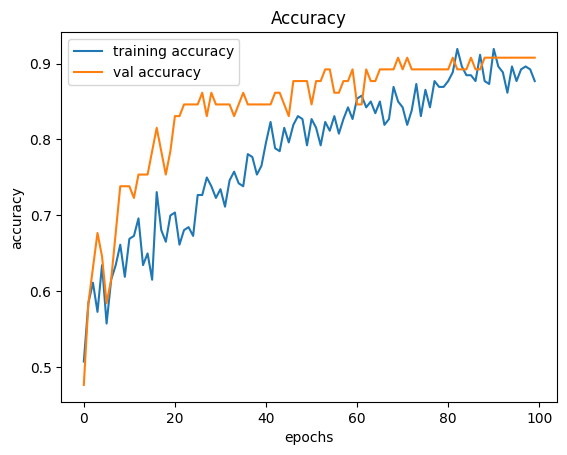

In [50]:
# Plotting graph for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

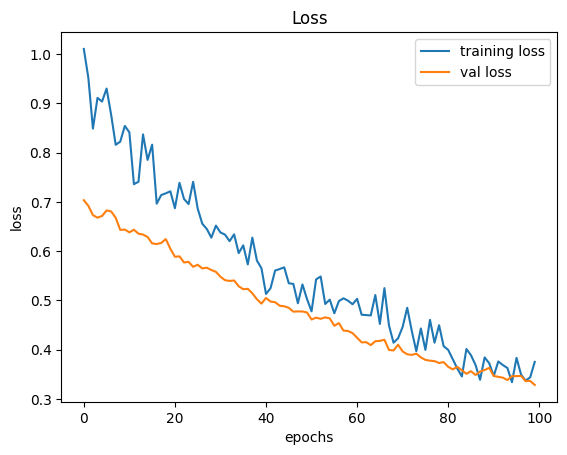

In [51]:
# Plotting graph for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [52]:
model = tf.keras.models.load_model('model-nasnet.h5')
pred = model.predict(X_test)
X_preds = []
Y_preds = []
for i in range(30):
    score = tf.nn.softmax(pred[i])
    score = np.argmax(score)
    X_preds.append(score)
    y = np.argmax(y_test[i])
    Y_preds.append(y)
print(X_preds)
print(Y_preds)

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7ff371c5f490> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step 
[np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
[np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


In [53]:
total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(pred)):
    if np.argmax(pred[i]) == np.argmax(y_test[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)     
    total += 1
    
print('Total-test-data;', total, '\naccurately-predicted-data:', accurate, '\nwrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 65 
accurately-predicted-data: 59 
wrongly-predicted-data:  6
Accuracy: 90.769 %


## Model D - DENSENET121

In [54]:
model_d = DenseNet121(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, CHANNEL)) 
x = model_d.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x) 
x = Dense(512, activation='relu')(x) 
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
preds=Dense(2, activation='softmax')(x)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [55]:
model = Model(inputs=model_d.input, outputs=preds)
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 8,619,074 (32.88 MB)

 Trainable params: 8,532,354 (32.55 MB)

 Non-trainable params: 86,720 (338.75 KB)

In [56]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [57]:
redlr = ReduceLROnPlateau(monitor='val_accuracy', 
                          factor=0.5,
                          patience=5, 
                          verbose=1, 
                          min_lr=1e-2)

checkpoint = ModelCheckpoint('densenet-model.h5', 
                             verbose=1, 
                             save_best_only=True)
monitor_val_acc = EarlyStopping(monitor = 'val_loss', patience = 15)

In [58]:
opt = Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.999, epsilon=1e-08)
loss = keras.losses.BinaryCrossentropy(from_logits=True)

# Compiling the model
model.compile(
    loss=loss, 
    optimizer=opt, 
    metrics=['accuracy'])

In [59]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range = 0.2, 
                             horizontal_flip=True, 
                             shear_range=0.2,
                             vertical_flip=True,
                             rotation_range=10,
                             fill_mode="nearest")
datagen.fit(X_train)
# Training the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=50), 
                    epochs=100, 
                    callbacks=[redlr, checkpoint, monitor_val_acc], 
                    validation_data=(X_test, y_test))

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4597 - loss: 1.0409
Epoch 1: val_loss improved from inf to 0.75381, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.4622 - loss: 1.0373 - val_accuracy: 0.2154 - val_loss: 0.7538 - learning_rate: 1.0000e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5239 - loss: 0.9954
Epoch 2: val_loss improved from 0.75381 to 0.71029, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.5233 - loss: 0.9973 - val_accuracy: 0.4308 - val_loss: 0.7103 - learning_rate: 1.0000e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6281 - loss: 0.8597
Epoch 3: val_loss improved from 0.71029 to 0.67588, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.6186 - loss: 0.8757 - val_accuracy: 0.6308 - val_loss: 0.6759 - learning_rate: 1.0000e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5386 - loss: 0.9874
Epoch 4: val_loss improved from 0.67588 to 0.64964, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.5430 - loss: 0.9836 - val_accuracy: 0.8000 - val_loss: 0.6496 - learning_rate: 1.0000e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5953 - loss: 0.9677
Epoch 5: val_loss improved from 0.64964 to 0.64327, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.5905 - loss: 0.9719 - val_accuracy: 0.8462 - val_loss: 0.6433 - learning_rate: 1.0000e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5406 - loss: 1.0054
Epoch 6: val_loss did not improve from 0.64327
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.5430 - loss: 0.9942 - val_accuracy: 0.7692 - val_loss: 0.6538 - learning_rate: 1.0000e-04
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6136 - loss: 0.8737
Epoch 7: val_loss improved from 0.64327 to 0.60462, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.6111 - loss: 0.8757 - val_accuracy: 0.8923 - val_loss: 0.6046 - learning_rate: 1.0000e-04
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5605 - loss: 0.9476
Epoch 8: val_loss improved from 0.60462 to 0.59631, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.5650 - loss: 0.9443 - val_accuracy: 0.8923 - val_loss: 0.5963 - learning_rate: 1.0000e-04
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6583 - loss: 0.8138
Epoch 9: val_loss improved from 0.59631 to 0.56491, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.6533 - loss: 0.8191 - val_accuracy: 0.9077 - val_loss: 0.5649 - learning_rate: 1.0000e-04
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6706 - loss: 0.8231
Epoch 10: val_loss improved from 0.56491 to 0.56393, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.6704 - loss: 0.8224 - val_accuracy: 0.8923 - val_loss: 0.5639 - learning_rate: 1.0000e-04
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5874 - loss: 0.9729
Epoch 11: val_loss improved from 0.56393 to 0.56037, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.5859 - loss: 0.9657 - val_accuracy: 0.8923 - val_loss: 0.5604 - learning_rate: 1.0000e-04
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6387 - loss: 0.8903
Epoch 12: val_loss improved from 0.56037 to 0.55714, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.6381 - loss: 0.8896 - val_accuracy: 0.8923 - val_loss: 0.5571 - learning_rate: 1.0000e-04
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 672s/step - accuracy: 0.6178 - loss: 0.8612  
Epoch 13: val_loss improved from 0.55714 to 0.55255, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 8763s 1752s/step - accuracy: 0.6197 - loss: 0.8626 - val_accuracy: 0.8923 - val_loss: 0.5526 - learning_rate: 1.0000e-04
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6563 - loss: 0.7398
Epoch 14: val_loss improved from 0.55255 to 0.54360, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.6516 - loss: 0.7456 - val_accuracy: 0.8923 - val_loss: 0.5436 - learning_rate: 1.0000e-04
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6441 - loss: 0.8296
Epoch 15: val_loss improved from 0.54360 to 0.54327, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.6400 - loss: 0.8335 - val_accuracy: 0.8923 - val_loss: 0.5433 - learning_rate: 1.0000e-04
Epoch 16/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5906 - loss: 0.8633
Epoch 16: val_loss improved from 0.54327 to 0.53536, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.5930 - loss: 0.8617 - val_accuracy: 0.8769 - val_loss: 0.5354 - learning_rate: 1.0000e-04
Epoch 17/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6310 - loss: 0.8095
Epoch 17: val_loss improved from 0.53536 to 0.51164, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.6310 - loss: 0.8113 - val_accuracy: 0.9231 - val_loss: 0.5116 - learning_rate: 1.0000e-04
Epoch 18/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6803 - loss: 0.7741
Epoch 18: val_loss improved from 0.51164 to 0.49726, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.6798 - loss: 0.7728 - val_accuracy: 0.9231 - val_loss: 0.4973 - learning_rate: 1.0000e-04
Epoch 19/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6336 - loss: 0.7593
Epoch 19: val_loss improved from 0.49726 to 0.48409, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6398 - loss: 0.7550 - val_accuracy: 0.9231 - val_loss: 0.4841 - learning_rate: 1.0000e-04
Epoch 20/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6161 - loss: 0.8279
Epoch 20: val_loss improved from 0.48409 to 0.48228, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6210 - loss: 0.8207 - val_accuracy: 0.9385 - val_loss: 0.4823 - learning_rate: 1.0000e-04
Epoch 21/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6624 - loss: 0.7553
Epoch 21: val_loss did not improve from 0.48228
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6622 - loss: 0.7549 - val_accuracy: 0.9231 - val_loss: 0.4968 - learning_rate: 1.0000e-04
Epoch 22/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6320 - loss: 0.7821
Epoch 22: val_loss did not improve from 0.48228
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6346 - loss: 0.7811 - val_accuracy: 0.9231 - val_loss: 0.4871 - learning_rate: 1.0000e-04
Epoch 23/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6330 - loss: 0.8061
Epoch 23: val_loss improved from 0.48228 to 0.47731, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.6399 - loss: 0.7944 - val_accuracy: 0.9385 - val_loss: 0.4773 - learning_rate: 1.0000e-04
Epoch 24/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6153 - loss: 0.8021
Epoch 24: val_loss improved from 0.47731 to 0.46615, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.6175 - loss: 0.7960 - val_accuracy: 0.9385 - val_loss: 0.4662 - learning_rate: 1.0000e-04
Epoch 25/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7055 - loss: 0.6981
Epoch 25: val_loss improved from 0.46615 to 0.45779, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.7041 - loss: 0.7012 - val_accuracy: 0.9385 - val_loss: 0.4578 - learning_rate: 1.0000e-04
Epoch 26/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6479 - loss: 0.6932
Epoch 26: val_loss improved from 0.45779 to 0.44195, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.6488 - loss: 0.6940 - val_accuracy: 0.9846 - val_loss: 0.4420 - learning_rate: 1.0000e-04
Epoch 27/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7183 - loss: 0.7584
Epoch 27: val_loss improved from 0.44195 to 0.42683, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.7190 - loss: 0.7496 - val_accuracy: 0.9846 - val_loss: 0.4268 - learning_rate: 1.0000e-04
Epoch 28/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.6573 - loss: 0.7767 
Epoch 28: val_loss improved from 0.42683 to 0.42328, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 109s 21s/step - accuracy: 0.6535 - loss: 0.7783 - val_accuracy: 0.9846 - val_loss: 0.4233 - learning_rate: 1.0000e-04
Epoch 29/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7173 - loss: 0.6612
Epoch 29: val_loss improved from 0.42328 to 0.42084, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.7115 - loss: 0.6696 - val_accuracy: 0.9692 - val_loss: 0.4208 - learning_rate: 1.0000e-04
Epoch 30/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6503 - loss: 0.7837
Epoch 30: val_loss improved from 0.42084 to 0.41632, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.6541 - loss: 0.7768 - val_accuracy: 0.9692 - val_loss: 0.4163 - learning_rate: 1.0000e-04
Epoch 31/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7140 - loss: 0.6054
Epoch 31: val_loss improved from 0.41632 to 0.40485, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.7169 - loss: 0.6067 - val_accuracy: 0.9846 - val_loss: 0.4048 - learning_rate: 1.0000e-04
Epoch 32/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7236 - loss: 0.6692
Epoch 32: val_loss improved from 0.40485 to 0.40333, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.7252 - loss: 0.6711 - val_accuracy: 0.9846 - val_loss: 0.4033 - learning_rate: 1.0000e-04
Epoch 33/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6695 - loss: 0.7336
Epoch 33: val_loss improved from 0.40333 to 0.39523, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.6727 - loss: 0.7274 - val_accuracy: 0.9692 - val_loss: 0.3952 - learning_rate: 1.0000e-04
Epoch 34/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7456 - loss: 0.6581
Epoch 34: val_loss did not improve from 0.39523
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.7429 - loss: 0.6595 - val_accuracy: 0.9846 - val_loss: 0.3975 - learning_rate: 1.0000e-04
Epoch 35/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7405 - loss: 0.6353
Epoch 35: val_loss did not improve from 0.39523
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.7402 - loss: 0.6391 - val_accuracy: 0.9846 - val_loss: 0.4003 - learning_rate: 1.0000e-04
Epoch 36/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7526 - loss: 0.7669
Epoch 36: val_loss improved from 0.39523 to 0.39293, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.7523 - loss: 0.7561 - val_accuracy: 0.9692 - val_loss: 0.3929 - learning_rate: 1.0000e-04
Epoch 37/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7431 - loss: 0.6063
Epoch 37: val_loss improved from 0.39293 to 0.37777, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.7436 - loss: 0.6079 - val_accuracy: 0.9846 - val_loss: 0.3778 - learning_rate: 1.0000e-04
Epoch 38/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7466 - loss: 0.6836
Epoch 38: val_loss improved from 0.37777 to 0.36168, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.7432 - loss: 0.6848 - val_accuracy: 0.9846 - val_loss: 0.3617 - learning_rate: 1.0000e-04
Epoch 39/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7447 - loss: 0.6426
Epoch 39: val_loss improved from 0.36168 to 0.35961, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.7476 - loss: 0.6409 - val_accuracy: 0.9846 - val_loss: 0.3596 - learning_rate: 1.0000e-04
Epoch 40/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7006 - loss: 0.7263
Epoch 40: val_loss improved from 0.35961 to 0.34184, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.7038 - loss: 0.7185 - val_accuracy: 0.9846 - val_loss: 0.3418 - learning_rate: 1.0000e-04
Epoch 41/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7707 - loss: 0.6741
Epoch 41: val_loss improved from 0.34184 to 0.32911, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.7722 - loss: 0.6671 - val_accuracy: 0.9846 - val_loss: 0.3291 - learning_rate: 1.0000e-04
Epoch 42/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7126 - loss: 0.6556
Epoch 42: val_loss improved from 0.32911 to 0.31582, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.7135 - loss: 0.6567 - val_accuracy: 0.9846 - val_loss: 0.3158 - learning_rate: 1.0000e-04
Epoch 43/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7442 - loss: 0.6039
Epoch 43: val_loss improved from 0.31582 to 0.31309, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7428 - loss: 0.6072 - val_accuracy: 0.9846 - val_loss: 0.3131 - learning_rate: 1.0000e-04
Epoch 44/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7459 - loss: 0.6036
Epoch 44: val_loss improved from 0.31309 to 0.30627, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.7492 - loss: 0.6034 - val_accuracy: 0.9846 - val_loss: 0.3063 - learning_rate: 1.0000e-04
Epoch 45/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7058 - loss: 0.6594
Epoch 45: val_loss improved from 0.30627 to 0.30197, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7082 - loss: 0.6548 - val_accuracy: 0.9846 - val_loss: 0.3020 - learning_rate: 1.0000e-04
Epoch 46/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7620 - loss: 0.6477
Epoch 46: val_loss improved from 0.30197 to 0.30183, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7636 - loss: 0.6409 - val_accuracy: 0.9846 - val_loss: 0.3018 - learning_rate: 1.0000e-04
Epoch 47/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7624 - loss: 0.6265
Epoch 47: val_loss improved from 0.30183 to 0.29839, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.7650 - loss: 0.6198 - val_accuracy: 0.9846 - val_loss: 0.2984 - learning_rate: 1.0000e-04
Epoch 48/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7166 - loss: 0.6920
Epoch 48: val_loss improved from 0.29839 to 0.29781, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7175 - loss: 0.6850 - val_accuracy: 0.9846 - val_loss: 0.2978 - learning_rate: 1.0000e-04
Epoch 49/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7517 - loss: 0.5837
Epoch 49: val_loss did not improve from 0.29781
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.7509 - loss: 0.5865 - val_accuracy: 0.9692 - val_loss: 0.3124 - learning_rate: 1.0000e-04
Epoch 50/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7526 - loss: 0.5857
Epoch 50: val_loss did not improve from 0.29781
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7549 - loss: 0.5858 - val_accuracy: 0.9692 - val_loss: 0.3210 - learning_rate: 1.0000e-04
Epoch 51/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7445 - loss: 0.6453
Epoch 51: val_loss did not improve from 0.29781
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.7492 - loss: 0.6349 - val_accuracy: 0.9846 - val_loss: 0.3181 - learning_rate: 1.0000e-04
Epoch 52/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s

6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.7785 - loss: 0.5612 - val_accuracy: 0.9846 - val_loss: 0.2825 - learning_rate: 1.0000e-04
Epoch 54/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7742 - loss: 0.6036
Epoch 54: val_loss improved from 0.28247 to 0.27914, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7707 - loss: 0.6049 - val_accuracy: 0.9692 - val_loss: 0.2791 - learning_rate: 1.0000e-04
Epoch 55/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7444 - loss: 0.6107
Epoch 55: val_loss did not improve from 0.27914
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.7490 - loss: 0.6044 - val_accuracy: 0.9692 - val_loss: 0.2797 - learning_rate: 1.0000e-04
Epoch 56/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7859 - loss: 0.6110
Epoch 56: val_loss did not improve from 0.27914
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.7896 - loss: 0.6078 - val_accuracy: 0.9846 - val_loss: 0.2807 - learning_rate: 1.0000e-04
Epoch 57/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7688 - loss: 0.5369
Epoch 57: val_loss improved from 0.27914 to 0.27599, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7678 - loss: 0.5392 - val_accuracy: 0.9846 - val_loss: 0.2760 - learning_rate: 1.0000e-04
Epoch 58/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7408 - loss: 0.5987
Epoch 58: val_loss did not improve from 0.27599
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.7481 - loss: 0.5895 - val_accuracy: 0.9846 - val_loss: 0.2858 - learning_rate: 1.0000e-04
Epoch 59/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8249 - loss: 0.5350
Epoch 59: val_loss did not improve from 0.27599
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8263 - loss: 0.5310 - val_accuracy: 0.9692 - val_loss: 0.2969 - learning_rate: 1.0000e-04
Epoch 60/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8061 - loss: 0.5261
Epoch 60: val_loss did not improve from 0.27599
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.8058 - loss: 0.5267 - val_accuracy: 0.9692 - val_loss: 0.3074 - learning_rate: 1.0000e-04
Epoch 61/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s

6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8361 - loss: 0.5380 - val_accuracy: 0.9692 - val_loss: 0.2679 - learning_rate: 1.0000e-04
Epoch 64/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8110 - loss: 0.5059
Epoch 64: val_loss did not improve from 0.26794
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8106 - loss: 0.5080 - val_accuracy: 0.9692 - val_loss: 0.2727 - learning_rate: 1.0000e-04
Epoch 65/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8110 - loss: 0.5059
Epoch 65: val_loss did not improve from 0.26794
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8094 - loss: 0.5100 - val_accuracy: 0.9692 - val_loss: 0.2747 - learning_rate: 1.0000e-04
Epoch 66/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8642 - loss: 0.4934
Epoch 66: val_loss did not improve from 0.26794
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8622 - loss: 0.4955 - val_accuracy: 0.9692 - val_loss: 0.2752 - learning_rate: 1.0000e-04
Epoch 67/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s

6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8620 - loss: 0.4307 - val_accuracy: 0.9692 - val_loss: 0.2640 - learning_rate: 1.0000e-04
Epoch 71/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8634 - loss: 0.4281
Epoch 71: val_loss improved from 0.26401 to 0.26072, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8615 - loss: 0.4298 - val_accuracy: 0.9846 - val_loss: 0.2607 - learning_rate: 1.0000e-04
Epoch 72/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8829 - loss: 0.4377
Epoch 72: val_loss did not improve from 0.26072
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8782 - loss: 0.4421 - val_accuracy: 0.9846 - val_loss: 0.2708 - learning_rate: 1.0000e-04
Epoch 73/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8272 - loss: 0.5066
Epoch 73: val_loss improved from 0.26072 to 0.25989, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8266 - loss: 0.5074 - val_accuracy: 0.9846 - val_loss: 0.2599 - learning_rate: 1.0000e-04
Epoch 74/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8393 - loss: 0.5071
Epoch 74: val_loss improved from 0.25989 to 0.25843, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8392 - loss: 0.5022 - val_accuracy: 0.9846 - val_loss: 0.2584 - learning_rate: 1.0000e-04
Epoch 75/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8545 - loss: 0.4559
Epoch 75: val_loss improved from 0.25843 to 0.25253, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8555 - loss: 0.4565 - val_accuracy: 0.9692 - val_loss: 0.2525 - learning_rate: 1.0000e-04
Epoch 76/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8425 - loss: 0.4570
Epoch 76: val_loss did not improve from 0.25253
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8447 - loss: 0.4550 - val_accuracy: 0.9692 - val_loss: 0.2539 - learning_rate: 1.0000e-04
Epoch 77/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8683 - loss: 0.4392
Epoch 77: val_loss did not improve from 0.25253
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8646 - loss: 0.4452 - val_accuracy: 0.9846 - val_loss: 0.2617 - learning_rate: 1.0000e-04
Epoch 78/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8847 - loss: 0.3695
Epoch 78: val_loss did not improve from 0.25253
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8792 - loss: 0.3774 - val_accuracy: 0.9846 - val_loss: 0.2588 - learning_rate: 1.0000e-04
Epoch 79/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s

6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8408 - loss: 0.4460 - val_accuracy: 0.9846 - val_loss: 0.2498 - learning_rate: 1.0000e-04
Epoch 80/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8187 - loss: 0.4344
Epoch 80: val_loss did not improve from 0.24976
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8221 - loss: 0.4303 - val_accuracy: 0.9846 - val_loss: 0.2544 - learning_rate: 1.0000e-04
Epoch 81/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8312 - loss: 0.4547
Epoch 81: val_loss did not improve from 0.24976
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8328 - loss: 0.4550 - val_accuracy: 0.9846 - val_loss: 0.2570 - learning_rate: 1.0000e-04
Epoch 82/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8215 - loss: 0.4721
Epoch 82: val_loss improved from 0.24976 to 0.24546, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8228 - loss: 0.4668 - val_accuracy: 0.9846 - val_loss: 0.2455 - learning_rate: 1.0000e-04
Epoch 83/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8331 - loss: 0.5018
Epoch 83: val_loss improved from 0.24546 to 0.24028, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8350 - loss: 0.4959 - val_accuracy: 0.9846 - val_loss: 0.2403 - learning_rate: 1.0000e-04
Epoch 84/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8584 - loss: 0.4376
Epoch 84: val_loss did not improve from 0.24028
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.8616 - loss: 0.4356 - val_accuracy: 0.9846 - val_loss: 0.2415 - learning_rate: 1.0000e-04
Epoch 85/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8757 - loss: 0.3918
Epoch 85: val_loss improved from 0.24028 to 0.23722, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8748 - loss: 0.3966 - val_accuracy: 0.9692 - val_loss: 0.2372 - learning_rate: 1.0000e-04
Epoch 86/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8958 - loss: 0.4400
Epoch 86: val_loss did not improve from 0.23722
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8920 - loss: 0.4424 - val_accuracy: 0.9692 - val_loss: 0.2419 - learning_rate: 1.0000e-04
Epoch 87/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8693 - loss: 0.4353
Epoch 87: val_loss did not improve from 0.23722
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8660 - loss: 0.4358 - val_accuracy: 0.9538 - val_loss: 0.2381 - learning_rate: 1.0000e-04
Epoch 88/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8658 - loss: 0.4395
Epoch 88: val_loss did not improve from 0.23722
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8674 - loss: 0.4360 - val_accuracy: 0.9538 - val_loss: 0.2404 - learning_rate: 1.0000e-04
Epoch 89/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s

6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8630 - loss: 0.4621 - val_accuracy: 0.9538 - val_loss: 0.2307 - learning_rate: 1.0000e-04
Epoch 90/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7892 - loss: 0.5142
Epoch 90: val_loss improved from 0.23071 to 0.22879, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.7979 - loss: 0.5078 - val_accuracy: 0.9538 - val_loss: 0.2288 - learning_rate: 1.0000e-04
Epoch 91/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9033 - loss: 0.3648
Epoch 91: val_loss improved from 0.22879 to 0.22664, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9034 - loss: 0.3668 - val_accuracy: 0.9692 - val_loss: 0.2266 - learning_rate: 1.0000e-04
Epoch 92/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8316 - loss: 0.4071
Epoch 92: val_loss did not improve from 0.22664
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8326 - loss: 0.4073 - val_accuracy: 0.9692 - val_loss: 0.2335 - learning_rate: 1.0000e-04
Epoch 93/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8659 - loss: 0.4151
Epoch 93: val_loss did not improve from 0.22664
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8659 - loss: 0.4148 - val_accuracy: 0.9692 - val_loss: 0.2278 - learning_rate: 1.0000e-04
Epoch 94/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8957 - loss: 0.3697
Epoch 94: val_loss improved from 0.22664 to 0.22180, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.8941 - loss: 0.3711 - val_accuracy: 0.9846 - val_loss: 0.2218 - learning_rate: 1.0000e-04
Epoch 95/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8915 - loss: 0.3838
Epoch 95: val_loss did not improve from 0.22180
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8911 - loss: 0.3850 - val_accuracy: 0.9692 - val_loss: 0.2257 - learning_rate: 1.0000e-04
Epoch 96/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8794 - loss: 0.3794
Epoch 96: val_loss did not improve from 0.22180
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8774 - loss: 0.3827 - val_accuracy: 0.9538 - val_loss: 0.2353 - learning_rate: 1.0000e-04
Epoch 97/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8567 - loss: 0.4387
Epoch 97: val_loss did not improve from 0.22180
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8585 - loss: 0.4353 - val_accuracy: 0.9538 - val_loss: 0.2333 - learning_rate: 1.0000e-04
Epoch 98/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s

6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8423 - loss: 0.4636 - val_accuracy: 0.9538 - val_loss: 0.2156 - learning_rate: 1.0000e-04
Epoch 100/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8595 - loss: 0.3864
Epoch 100: val_loss improved from 0.21560 to 0.21166, saving model to densenet-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.8609 - loss: 0.3849 - val_accuracy: 0.9692 - val_loss: 0.2117 - learning_rate: 1.0000e-04


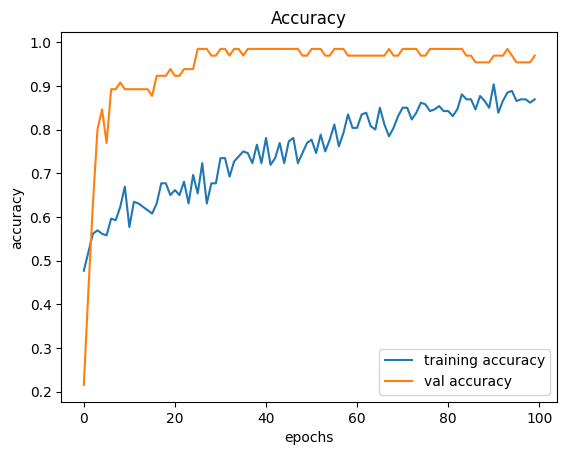

In [60]:
# Plotting graph for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

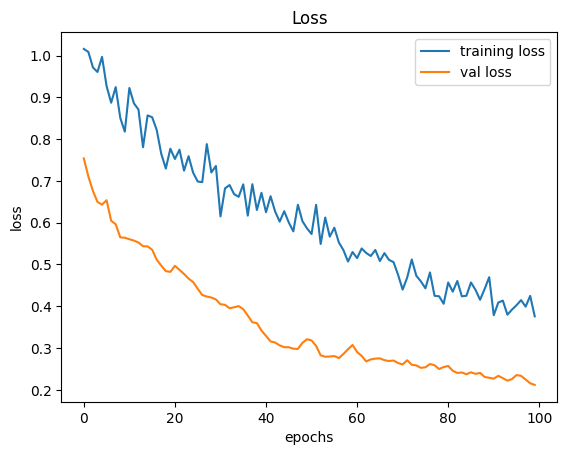

In [61]:
# Plotting graph for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [62]:
model = tf.keras.models.load_model('densenet-model.h5')
pred = model.predict(X_test)
X_preds = []
Y_preds = []
for i in range(30):
    score = tf.nn.softmax(pred[i])
    score = np.argmax(score)
    X_preds.append(score)
    y = np.argmax(y_test[i])
    Y_preds.append(y)
print(X_preds)
print(Y_preds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step
[np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1)]
[np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


In [63]:
total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(pred)):
    if np.argmax(pred[i]) == np.argmax(y_test[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)     
    total += 1
    
print('Total-test-data;', total, '\naccurately-predicted-data:', accurate, '\nwrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 65 
accurately-predicted-data: 63 
wrongly-predicted-data:  2
Accuracy: 96.923 %


## Model E - RESNET50

In [64]:
model_d = ResNet50(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, CHANNEL)) 
x = model_d.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x) 
x = Dense(512, activation='relu')(x) 
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
preds=Dense(2, activation='softmax')(x)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [65]:
model = Model(inputs=model_d.input, outputs=preds)
model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,221,954 (100.03 MB)

 Trainable params: 26,163,714 (99.81 MB)

 Non-trainable params: 58,240 (227.50 KB)

In [66]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [67]:
redlr = ReduceLROnPlateau(monitor='val_accuracy', 
                          factor=0.5,
                          patience=5, 
                          verbose=1, 
                          min_lr=1e-2)

checkpoint = ModelCheckpoint('resnet50-model.h5', 
                             verbose=1, 
                             save_best_only=True)
monitor_val_acc = EarlyStopping(monitor = 'val_loss', patience = 15)

In [68]:
opt = Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.999, epsilon=1e-08)
loss = keras.losses.BinaryCrossentropy(from_logits=True)

# Compiling the model
model.compile(
    loss=loss, 
    optimizer=opt, 
    metrics=['accuracy'])

: 

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range = 0.2, 
                             horizontal_flip=True, 
                             shear_range=0.2,
                             vertical_flip=True,
                             rotation_range=10,
                             fill_mode="nearest")
datagen.fit(X_train)
# Training the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=50), 
                    epochs=100, 
                    callbacks=[redlr, checkpoint, monitor_val_acc], 
                    validation_data=(X_test, y_test))

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5364 - loss: 1.0403
Epoch 1: val_loss improved from inf to 0.94458, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.5356 - loss: 1.0357 - val_accuracy: 0.0462 - val_loss: 0.9446 - learning_rate: 1.0000e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5854 - loss: 0.8653
Epoch 2: val_loss did not improve from 0.94458
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5820 - loss: 0.8714 - val_accuracy: 0.0462 - val_loss: 0.9757 - learning_rate: 1.0000e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5761 - loss: 0.9575
Epoch 3: val_loss did not improve from 0.94458
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5784 - loss: 0.9499 - val_accuracy: 0.0462 - val_loss: 0.9912 - learning_rate: 1.0000e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5344 - loss: 0.9951
Epoch 4: val_loss did not improve from 0.94458
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.5367 - loss: 0.9884 - val_accuracy: 0.0462 - val_loss: 0.9978 - learning_rate: 1.0000e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step 

6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5878 - loss: 0.8814 - val_accuracy: 0.0462 - val_loss: 0.9432 - learning_rate: 1.0000e-04
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6325 - loss: 0.9020
Epoch 9: val_loss improved from 0.94319 to 0.90593, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.6301 - loss: 0.8994 - val_accuracy: 0.0462 - val_loss: 0.9059 - learning_rate: 1.0000e-04
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6100 - loss: 0.8839
Epoch 10: val_loss improved from 0.90593 to 0.86025, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6081 - loss: 0.8819 - val_accuracy: 0.0462 - val_loss: 0.8602 - learning_rate: 1.0000e-04
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5499 - loss: 0.8827
Epoch 11: val_loss improved from 0.86025 to 0.83701, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5505 - loss: 0.8854 - val_accuracy: 0.0462 - val_loss: 0.8370 - learning_rate: 1.0000e-04
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5523 - loss: 0.9285
Epoch 12: val_loss did not improve from 0.83701
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.5558 - loss: 0.9200 - val_accuracy: 0.0462 - val_loss: 0.8430 - learning_rate: 1.0000e-04
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6193 - loss: 0.7858
Epoch 13: val_loss did not improve from 0.83701
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.6188 - loss: 0.7873 - val_accuracy: 0.0462 - val_loss: 0.8448 - learning_rate: 1.0000e-04
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5972 - loss: 0.8673
Epoch 14: val_loss improved from 0.83701 to 0.80444, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5937 - loss: 0.8695 - val_accuracy: 0.0462 - val_loss: 0.8044 - learning_rate: 1.0000e-04
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6530 - loss: 0.7249
Epoch 15: val_loss improved from 0.80444 to 0.76918, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6477 - loss: 0.7264 - val_accuracy: 0.0462 - val_loss: 0.7692 - learning_rate: 1.0000e-04
Epoch 16/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6339 - loss: 0.8234
Epoch 16: val_loss did not improve from 0.76918
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.6318 - loss: 0.8220 - val_accuracy: 0.0462 - val_loss: 0.7726 - learning_rate: 1.0000e-04
Epoch 17/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6814 - loss: 0.7895
Epoch 17: val_loss did not improve from 0.76918
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6824 - loss: 0.7895 - val_accuracy: 0.0462 - val_loss: 0.7745 - learning_rate: 1.0000e-04
Epoch 18/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6135 - loss: 0.7962
Epoch 18: val_loss did not improve from 0.76918
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.6182 - loss: 0.7954 - val_accuracy: 0.0462 - val_loss: 0.7737 - learning_rate: 1.0000e-04
Epoch 19/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7s

6/6 ━━━━━━━━━━━━━━━━━━━━ 47s 8s/step - accuracy: 0.6530 - loss: 0.7751 - val_accuracy: 0.0769 - val_loss: 0.7501 - learning_rate: 1.0000e-04
Epoch 20/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6648 - loss: 0.7858
Epoch 20: val_loss did not improve from 0.75010
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.6638 - loss: 0.7841 - val_accuracy: 0.0462 - val_loss: 0.7795 - learning_rate: 1.0000e-04
Epoch 21/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6816 - loss: 0.7514
Epoch 21: val_loss improved from 0.75010 to 0.71437, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6809 - loss: 0.7542 - val_accuracy: 0.4462 - val_loss: 0.7144 - learning_rate: 1.0000e-04
Epoch 22/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7016 - loss: 0.6994
Epoch 22: val_loss did not improve from 0.71437
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7014 - loss: 0.7003 - val_accuracy: 0.4615 - val_loss: 0.7175 - learning_rate: 1.0000e-04
Epoch 23/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7190 - loss: 0.7751
Epoch 23: val_loss improved from 0.71437 to 0.70993, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.7163 - loss: 0.7702 - val_accuracy: 0.5077 - val_loss: 0.7099 - learning_rate: 1.0000e-04
Epoch 24/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7358 - loss: 0.7618
Epoch 24: val_loss improved from 0.70993 to 0.70270, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.7274 - loss: 0.7655 - val_accuracy: 0.5385 - val_loss: 0.7027 - learning_rate: 1.0000e-04
Epoch 25/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6742 - loss: 0.7874
Epoch 25: val_loss did not improve from 0.70270
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.6713 - loss: 0.7865 - val_accuracy: 0.5385 - val_loss: 0.7123 - learning_rate: 1.0000e-04
Epoch 26/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6812 - loss: 0.7385
Epoch 26: val_loss did not improve from 0.70270
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.6822 - loss: 0.7362 - val_accuracy: 0.5385 - val_loss: 0.7129 - learning_rate: 1.0000e-04
Epoch 27/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7540 - loss: 0.6911
Epoch 27: val_loss improved from 0.70270 to 0.68176, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.7534 - loss: 0.6911 - val_accuracy: 0.6462 - val_loss: 0.6818 - learning_rate: 1.0000e-04
Epoch 28/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6430 - loss: 0.7226
Epoch 28: val_loss did not improve from 0.68176
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.6479 - loss: 0.7226 - val_accuracy: 0.6308 - val_loss: 0.6921 - learning_rate: 1.0000e-04
Epoch 29/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7345 - loss: 0.7138
Epoch 29: val_loss improved from 0.68176 to 0.67007, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7306 - loss: 0.7163 - val_accuracy: 0.6769 - val_loss: 0.6701 - learning_rate: 1.0000e-04
Epoch 30/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7650 - loss: 0.7419
Epoch 30: val_loss improved from 0.67007 to 0.63474, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.7617 - loss: 0.7395 - val_accuracy: 0.7538 - val_loss: 0.6347 - learning_rate: 1.0000e-04
Epoch 31/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6958 - loss: 0.7694
Epoch 31: val_loss improved from 0.63474 to 0.61076, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.6964 - loss: 0.7663 - val_accuracy: 0.8154 - val_loss: 0.6108 - learning_rate: 1.0000e-04
Epoch 32/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6183 - loss: 0.8102
Epoch 32: val_loss did not improve from 0.61076
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.6196 - loss: 0.8055 - val_accuracy: 0.8000 - val_loss: 0.6305 - learning_rate: 1.0000e-04
Epoch 33/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6938 - loss: 0.7605
Epoch 33: val_loss improved from 0.61076 to 0.59755, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6941 - loss: 0.7563 - val_accuracy: 0.8000 - val_loss: 0.5975 - learning_rate: 1.0000e-04
Epoch 34/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7067 - loss: 0.6619
Epoch 34: val_loss improved from 0.59755 to 0.57453, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7074 - loss: 0.6654 - val_accuracy: 0.8462 - val_loss: 0.5745 - learning_rate: 1.0000e-04
Epoch 35/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6581 - loss: 0.7417
Epoch 35: val_loss improved from 0.57453 to 0.54386, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.6624 - loss: 0.7340 - val_accuracy: 0.9077 - val_loss: 0.5439 - learning_rate: 1.0000e-04
Epoch 36/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6842 - loss: 0.7691
Epoch 36: val_loss improved from 0.54386 to 0.52536, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6843 - loss: 0.7656 - val_accuracy: 0.9385 - val_loss: 0.5254 - learning_rate: 1.0000e-04
Epoch 37/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6850 - loss: 0.7305
Epoch 37: val_loss improved from 0.52536 to 0.52459, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.6877 - loss: 0.7273 - val_accuracy: 0.9077 - val_loss: 0.5246 - learning_rate: 1.0000e-04
Epoch 38/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7676 - loss: 0.6723
Epoch 38: val_loss improved from 0.52459 to 0.52006, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7635 - loss: 0.6778 - val_accuracy: 0.9077 - val_loss: 0.5201 - learning_rate: 1.0000e-04
Epoch 39/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6937 - loss: 0.7449
Epoch 39: val_loss improved from 0.52006 to 0.51227, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6935 - loss: 0.7439 - val_accuracy: 0.9385 - val_loss: 0.5123 - learning_rate: 1.0000e-04
Epoch 40/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7728 - loss: 0.6248
Epoch 40: val_loss improved from 0.51227 to 0.47523, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.7684 - loss: 0.6263 - val_accuracy: 0.9385 - val_loss: 0.4752 - learning_rate: 1.0000e-04
Epoch 41/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7695 - loss: 0.6330
Epoch 41: val_loss improved from 0.47523 to 0.46595, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.7623 - loss: 0.6429 - val_accuracy: 0.9538 - val_loss: 0.4659 - learning_rate: 1.0000e-04
Epoch 42/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7336 - loss: 0.6234
Epoch 42: val_loss improved from 0.46595 to 0.46103, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.7354 - loss: 0.6236 - val_accuracy: 0.9538 - val_loss: 0.4610 - learning_rate: 1.0000e-04
Epoch 43/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7162 - loss: 0.6516
Epoch 43: val_loss improved from 0.46103 to 0.44752, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.7188 - loss: 0.6492 - val_accuracy: 0.9538 - val_loss: 0.4475 - learning_rate: 1.0000e-04
Epoch 44/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7301 - loss: 0.6521
Epoch 44: val_loss improved from 0.44752 to 0.44651, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - accuracy: 0.7313 - loss: 0.6549 - val_accuracy: 0.9538 - val_loss: 0.4465 - learning_rate: 1.0000e-04
Epoch 45/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7533 - loss: 0.6332
Epoch 45: val_loss did not improve from 0.44651
6/6 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7545 - loss: 0.6334 - val_accuracy: 0.9538 - val_loss: 0.4535 - learning_rate: 1.0000e-04
Epoch 46/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6706 - loss: 0.7714
Epoch 46: val_loss did not improve from 0.44651
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.6737 - loss: 0.7644 - val_accuracy: 0.9538 - val_loss: 0.4552 - learning_rate: 1.0000e-04
Epoch 47/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7497 - loss: 0.6010
Epoch 47: val_loss improved from 0.44651 to 0.44314, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.7509 - loss: 0.6026 - val_accuracy: 0.9538 - val_loss: 0.4431 - learning_rate: 1.0000e-04
Epoch 48/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7540 - loss: 0.6780
Epoch 48: val_loss improved from 0.44314 to 0.43896, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 10s/step - accuracy: 0.7562 - loss: 0.6717 - val_accuracy: 0.9538 - val_loss: 0.4390 - learning_rate: 1.0000e-04
Epoch 49/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7709 - loss: 0.6493
Epoch 49: val_loss improved from 0.43896 to 0.43807, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.7728 - loss: 0.6455 - val_accuracy: 0.9538 - val_loss: 0.4381 - learning_rate: 1.0000e-04
Epoch 50/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7748 - loss: 0.5541
Epoch 50: val_loss improved from 0.43807 to 0.40981, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.7718 - loss: 0.5610 - val_accuracy: 0.9538 - val_loss: 0.4098 - learning_rate: 1.0000e-04
Epoch 51/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7262 - loss: 0.6345
Epoch 51: val_loss improved from 0.40981 to 0.40144, saving model to resnet50-model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.7280 - loss: 0.6340 - val_accuracy: 0.9538 - val_loss: 0.4014 - learning_rate: 1.0000e-04
Epoch 52/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.7947 - loss: 0.5766 
Epoch 52: val_loss did not improve from 0.40144
6/6 ━━━━━━━━━━━━━━━━━━━━ 375s 40s/step - accuracy: 0.7933 - loss: 0.5766 - val_accuracy: 0.9385 - val_loss: 0.4044 - learning_rate: 1.0000e-04
Epoch 53/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7336 - loss: 0.6385
Epoch 53: val_loss did not improve from 0.40144
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.7365 - loss: 0.6370 - val_accuracy: 0.9538 - val_loss: 0.4022 - learning_rate: 1.0000e-04
Epoch 54/100
5/6 ━━━━━━━━━━━━━━━━━━━━ 49s 50s/step - accuracy: 0.7102 - loss: 0.5755 

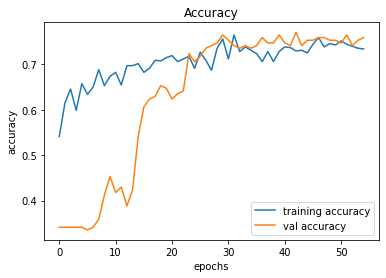

In [ ]:
# Plotting graph for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

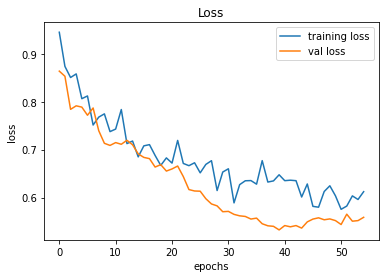

In [ ]:
# Plotting graph for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
pred = model.predict(X_test)
X_preds = []
Y_preds = []
for i in range(30):
    score = tf.nn.softmax(pred[i])
    score = np.argmax(score)
    X_preds.append(score)
    y = np.argmax(y_test[i])
    Y_preds.append(y)
print(X_preds)
print(Y_preds)

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [ ]:
total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(pred)):
    if np.argmax(pred[i]) == np.argmax(y_test[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)     
    total += 1
    
print('Total-test-data;', total, '\naccurately-predicted-data:', accurate, '\nwrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 170 
accurately-predicted-data: 129 
wrongly-predicted-data:  41
Accuracy: 75.882 %


## Test the models with test dataset

In [ ]:
test_path = os.path.join('/content/drive/My Drive/ARU/testDataset')

In [ ]:
train_neg_images = os.listdir(test_path + '/Negative/');
train_post_images = os.listdir(test_path + '/Positive/');

In [ ]:
neg_images = {'filename': train_neg_images}
neg_images = pd.DataFrame(neg_images)
neg_filename = neg_images['filename']

post_images = {'filename': train_post_images}
post_images = pd.DataFrame(post_images)
post_filename = post_images['filename']

In [ ]:
NUM_NEG_IMAGES = len(neg_images)
print(NUM_NEG_IMAGES)

50


In [ ]:
NUM_POST_IMAGES = len(post_images)
print(NUM_POST_IMAGES)

50


In [ ]:
# Building data list
test_negative = []
neg_label = []
for i in range(NUM_NEG_IMAGES):
    image = Image.open(test_path + '/Negative/' + neg_filename[i])
    # resize the image and convert into numpy array (224, 224)
    image = np.array(image.resize((WIDTH, HEIGHT)))
    test_negative.append(image)
    neg_label.append(0)

In [ ]:
# Building data list
test_positive = []
post_label = []
for i in range(NUM_POST_IMAGES):
    image = Image.open(test_path + '/Positive/' + post_filename[i])
    # resize the image and convert into numpy array (224, 224)
    image = np.array(image.resize((WIDTH, HEIGHT)))
    test_positive.append(image)
    post_label.append(1)

In [ ]:
test_X = np.array(test_negative + test_positive)
test_X = test_X / 255

In [ ]:
len(test_X)

100

In [ ]:
test_y = np.array(neg_label + post_label)

In [ ]:
RANGE = len(test_X)
RANGE

100

In [ ]:
test_y = keras.utils.to_categorical(test_y)

## Model A

In [ ]:
model = tf.keras.models.load_model('my_model.h5')

pred = model.predict(test_X)
X_preds = []
Y_preds = []

for i in range(RANGE):
    score = tf.nn.softmax(pred[i])
    score = np.argmax(score)
    X_preds.append(score)
    y = np.argmax(test_y[i])
    Y_preds.append(y)

print(X_preds)
print(Y_preds)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(pred)):
    if np.argmax(pred[i]) == np.argmax(test_y[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)     
    total += 1
    
print('Total-test-data:', total, '\naccurately-predicted-data:', accurate, '\nwrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data: 100 
accurately-predicted-data: 65 
wrongly-predicted-data:  35
Accuracy: 65.0 %


tf.Tensor(
[[38 12]
 [23 27]], shape=(2, 2), dtype=int32)


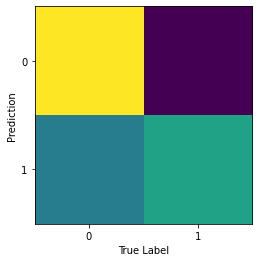

In [ ]:
c_matrix = tf.math.confusion_matrix(Y_preds, X_preds, num_classes=2)
print(c_matrix)
plt.imshow(c_matrix)
plt.xlabel('True Label')
plt.xticks(np.arange(2), [x for x in range(0, 2)])
plt.ylabel('Prediction')
plt.yticks(np.arange(2), [x for x in range(0, 2)])
plt.savefig('MC_OPT_L1L2_CM_final.pdf')
plt.show()

## Model B

In [ ]:
model = tf.keras.models.load_model('my_model-SGD.h5')

pred = model.predict(test_X)
X_preds = []
Y_preds = []

for i in range(RANGE):
    score = tf.nn.softmax(pred[i])
    score = np.argmax(score)
    X_preds.append(score)
    y = np.argmax(test_y[i])
    Y_preds.append(y)

print(X_preds)
print(Y_preds)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(pred)):
    if np.argmax(pred[i]) == np.argmax(test_y[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)     
    total += 1
    
print('Total-test-data:', total, '\naccurately-predicted-data:', accurate, '\nwrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data: 100 
accurately-predicted-data: 55 
wrongly-predicted-data:  45
Accuracy: 55.0 %


tf.Tensor(
[[43  7]
 [38 12]], shape=(2, 2), dtype=int32)


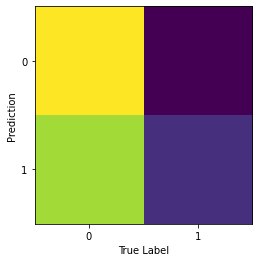

In [ ]:
c_matrix = tf.math.confusion_matrix(Y_preds, X_preds, num_classes=2)
print(c_matrix)
plt.imshow(c_matrix)
plt.xlabel('True Label')
plt.xticks(np.arange(2), [x for x in range(0, 2)])
plt.ylabel('Prediction')
plt.yticks(np.arange(2), [x for x in range(0, 2)])
plt.savefig('MC_OPT_L1L2_CM_final.pdf')
plt.show()

## Model C - NASNET

In [ ]:
model = tf.keras.models.load_model('model-nasnet.h5')

pred = model.predict(test_X)
X_preds = []
Y_preds = []

for i in range(RANGE):
    score = tf.nn.softmax(pred[i])
    score = np.argmax(score)
    X_preds.append(score)
    y = np.argmax(test_y[i])
    Y_preds.append(y)

print(X_preds)
print(Y_preds)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(pred)):
    if np.argmax(pred[i]) == np.argmax(test_y[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)     
    total += 1
    
print('Total-test-data:', total, '\naccurately-predicted-data:', accurate, '\nwrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data: 100 
accurately-predicted-data: 79 
wrongly-predicted-data:  21
Accuracy: 79.0 %


tf.Tensor(
[[40 10]
 [11 39]], shape=(2, 2), dtype=int32)


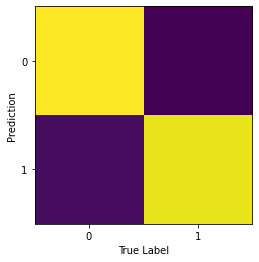

In [ ]:
c_matrix = tf.math.confusion_matrix(Y_preds, X_preds, num_classes=2)
print(c_matrix)
plt.imshow(c_matrix)
plt.xlabel('True Label')
plt.xticks(np.arange(2), [x for x in range(0, 2)])
plt.ylabel('Prediction')
plt.yticks(np.arange(2), [x for x in range(0, 2)])
plt.savefig('MC_OPT_L1L2_CM_final.pdf')
plt.show()

## Model D - DENSENET

In [ ]:
model = tf.keras.models.load_model('densenet-model.h5')

pred = model.predict(test_X)
X_preds = []
Y_preds = []

for i in range(RANGE):
    score = tf.nn.softmax(pred[i])
    score = np.argmax(score)
    X_preds.append(score)
    y = np.argmax(test_y[i])
    Y_preds.append(y)

print(X_preds)
print(Y_preds)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(pred)):
    if np.argmax(pred[i]) == np.argmax(test_y[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)     
    total += 1
    
print('Total-test-data:', total, '\naccurately-predicted-data:', accurate, '\nwrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data: 100 
accurately-predicted-data: 79 
wrongly-predicted-data:  21
Accuracy: 79.0 %


tf.Tensor(
[[38 12]
 [ 9 41]], shape=(2, 2), dtype=int32)


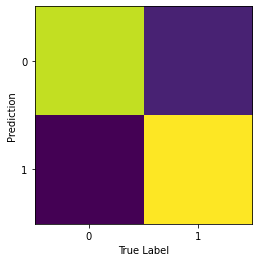

In [ ]:
c_matrix = tf.math.confusion_matrix(Y_preds, X_preds, num_classes=2)
print(c_matrix)
plt.imshow(c_matrix)
plt.xlabel('True Label')
plt.xticks(np.arange(2), [x for x in range(0, 2)])
plt.ylabel('Prediction')
plt.yticks(np.arange(2), [x for x in range(0, 2)])
plt.savefig('MC_OPT_L1L2_CM_final.pdf')
plt.show()

## Model E

In [ ]:
model = tf.keras.models.load_model('resnet50-model.h5')

pred = model.predict(test_X)
X_preds = []
Y_preds = []

for i in range(RANGE):
    score = tf.nn.softmax(pred[i])
    score = np.argmax(score)
    X_preds.append(score)
    y = np.argmax(test_y[i])
    Y_preds.append(y)

print(X_preds)
print(Y_preds)

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(pred)):
    if np.argmax(pred[i]) == np.argmax(test_y[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)     
    total += 1
    
print('Total-test-data:', total, '\naccurately-predicted-data:', accurate, '\nwrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data: 100 
accurately-predicted-data: 56 
wrongly-predicted-data:  44
Accuracy: 56.0 %


tf.Tensor(
[[36 14]
 [30 20]], shape=(2, 2), dtype=int32)


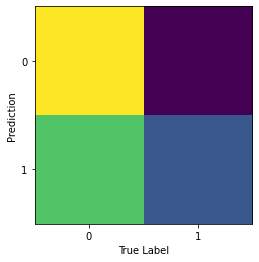

In [ ]:
c_matrix = tf.math.confusion_matrix(Y_preds, X_preds, num_classes=2)
print(c_matrix)
plt.imshow(c_matrix)
plt.xlabel('True Label')
plt.xticks(np.arange(2), [x for x in range(0, 2)])
plt.ylabel('Prediction')
plt.yticks(np.arange(2), [x for x in range(0, 2)])
plt.savefig('MC_OPT_L1L2_CM_final.pdf')
plt.show()

# Test the models with fake image dataset

In [ ]:
train_neg_images = os.listdir(test_path + '/Negative-GAN/');
train_post_images = os.listdir(test_path + '/Positive-GAN/');

In [ ]:
neg_images = {'filename': train_neg_images}
neg_images = pd.DataFrame(neg_images)
neg_filename = neg_images['filename']

post_images = {'filename': train_post_images}
post_images = pd.DataFrame(post_images)
post_filename = post_images['filename']

In [ ]:
NUM_NEG_IMAGES = len(neg_images)
print(NUM_NEG_IMAGES)

50


In [ ]:
NUM_POST_IMAGES = len(post_images)
print(NUM_POST_IMAGES)

50


In [ ]:
# Building data list
test_negative = []
neg_label = []
for i in range(NUM_NEG_IMAGES):
    image = Image.open(test_path + '/Negative-GAN/' + neg_filename[i])
    # resize the image and convert into numpy array (224, 224)
    image = np.array(image.resize((WIDTH, HEIGHT)))
    test_negative.append(image)
    neg_label.append(0)

In [ ]:
# Building data list
test_positive = []
post_label = []
for i in range(NUM_POST_IMAGES):
    image = Image.open(test_path + '/Positive-GAN/' + post_filename[i])
    # resize the image and convert into numpy array (224, 224)
    image = np.array(image.resize((WIDTH, HEIGHT)))
    test_positive.append(image)
    post_label.append(1)

In [ ]:
test_X = np.array(test_negative + test_positive)
test_X = test_X / 255
print(len(test_X))

test_y = np.array(neg_label + post_label)

RANGE = len(test_X)
print(RANGE)

test_y = keras.utils.to_categorical(test_y)

100
100


## Model A

In [ ]:
model = tf.keras.models.load_model('my_model.h5')

pred = model.predict(test_X)
X_preds = []
Y_preds = []

for i in range(RANGE):
    score = tf.nn.softmax(pred[i])
    score = np.argmax(score)
    X_preds.append(score)
    y = np.argmax(test_y[i])
    Y_preds.append(y)

print(X_preds)
print(Y_preds)

[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(pred)):
    if np.argmax(pred[i]) == np.argmax(test_y[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)     
    total += 1
    
print('Total-test-data:', total, '\naccurately-predicted-data:', accurate, '\nwrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data: 100 
accurately-predicted-data: 63 
wrongly-predicted-data:  37
Accuracy: 63.0 %


tf.Tensor(
[[16 34]
 [ 3 47]], shape=(2, 2), dtype=int32)


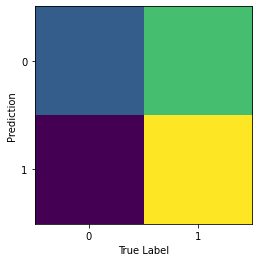

In [ ]:
c_matrix = tf.math.confusion_matrix(Y_preds, X_preds, num_classes=2)
print(c_matrix)
plt.imshow(c_matrix)
plt.xlabel('True Label')
plt.xticks(np.arange(2), [x for x in range(0, 2)])
plt.ylabel('Prediction')
plt.yticks(np.arange(2), [x for x in range(0, 2)])
plt.savefig('MC_OPT_L1L2_CM_final.pdf')
plt.show()

## Model B

In [ ]:
model = tf.keras.models.load_model('my_model-SGD.h5')

pred = model.predict(test_X)
X_preds = []
Y_preds = []

for i in range(RANGE):
    score = tf.nn.softmax(pred[i])
    score = np.argmax(score)
    X_preds.append(score)
    y = np.argmax(test_y[i])
    Y_preds.append(y)

print(X_preds)
print(Y_preds)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(pred)):
    if np.argmax(pred[i]) == np.argmax(test_y[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)     
    total += 1
    
print('Total-test-data:', total, '\naccurately-predicted-data:', accurate, '\nwrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data: 100 
accurately-predicted-data: 65 
wrongly-predicted-data:  35
Accuracy: 65.0 %


tf.Tensor(
[[45  5]
 [30 20]], shape=(2, 2), dtype=int32)


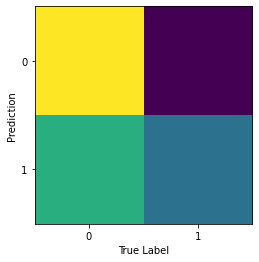

In [ ]:
c_matrix = tf.math.confusion_matrix(Y_preds, X_preds, num_classes=2)
print(c_matrix)
plt.imshow(c_matrix)
plt.xlabel('True Label')
plt.xticks(np.arange(2), [x for x in range(0, 2)])
plt.ylabel('Prediction')
plt.yticks(np.arange(2), [x for x in range(0, 2)])
plt.savefig('MC_OPT_L1L2_CM_final.pdf')
plt.show()

## Model - D - DENSENET

In [ ]:
model = tf.keras.models.load_model('densenet-model.h5')

pred = model.predict(test_X)
X_preds = []
Y_preds = []

for i in range(RANGE):
    score = tf.nn.softmax(pred[i])
    score = np.argmax(score)
    X_preds.append(score)
    y = np.argmax(test_y[i])
    Y_preds.append(y)

print(X_preds)
print(Y_preds)

[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(pred)):
    if np.argmax(pred[i]) == np.argmax(test_y[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)     
    total += 1
    
print('Total-test-data:', total, '\naccurately-predicted-data:', accurate, '\nwrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data: 100 
accurately-predicted-data: 77 
wrongly-predicted-data:  23
Accuracy: 77.0 %


tf.Tensor(
[[39 11]
 [12 38]], shape=(2, 2), dtype=int32)


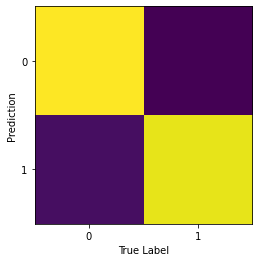

In [ ]:
c_matrix = tf.math.confusion_matrix(Y_preds, X_preds, num_classes=2)
print(c_matrix)
plt.imshow(c_matrix)
plt.xlabel('True Label')
plt.xticks(np.arange(2), [x for x in range(0, 2)])
plt.ylabel('Prediction')
plt.yticks(np.arange(2), [x for x in range(0, 2)])
plt.savefig('MC_OPT_L1L2_CM_final.pdf')
plt.show()

## Model C - NASNET

In [ ]:
model = tf.keras.models.load_model('model-nasnet.h5')

pred = model.predict(test_X)
X_preds = []
Y_preds = []

for i in range(RANGE):
    score = tf.nn.softmax(pred[i])
    score = np.argmax(score)
    X_preds.append(score)
    y = np.argmax(test_y[i])
    Y_preds.append(y)

print(X_preds)
print(Y_preds)

[0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(pred)):
    if np.argmax(pred[i]) == np.argmax(test_y[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)     
    total += 1
    
print('Total-test-data:', total, '\naccurately-predicted-data:', accurate, '\nwrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data: 100 
accurately-predicted-data: 67 
wrongly-predicted-data:  33
Accuracy: 67.0 %


tf.Tensor(
[[33 17]
 [16 34]], shape=(2, 2), dtype=int32)


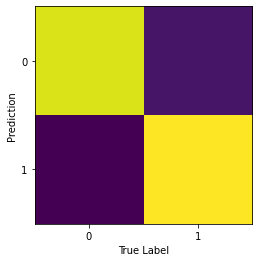

In [ ]:
c_matrix = tf.math.confusion_matrix(Y_preds, X_preds, num_classes=2)
print(c_matrix)
plt.imshow(c_matrix)
plt.xlabel('True Label')
plt.xticks(np.arange(2), [x for x in range(0, 2)])
plt.ylabel('Prediction')
plt.yticks(np.arange(2), [x for x in range(0, 2)])
plt.savefig('MC_OPT_L1L2_CM_final.pdf')
plt.show()

## Model E

In [ ]:
model = tf.keras.models.load_model('resnet50-model.h5')

pred = model.predict(test_X)
X_preds = []
Y_preds = []

for i in range(RANGE):
    score = tf.nn.softmax(pred[i])
    score = np.argmax(score)
    X_preds.append(score)
    y = np.argmax(test_y[i])
    Y_preds.append(y)

print(X_preds)
print(Y_preds)

[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(pred)):
    if np.argmax(pred[i]) == np.argmax(test_y[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)     
    total += 1
    
print('Total-test-data:', total, '\naccurately-predicted-data:', accurate, '\nwrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

tf.Tensor(
[[29 21]
 [14 36]], shape=(2, 2), dtype=int32)


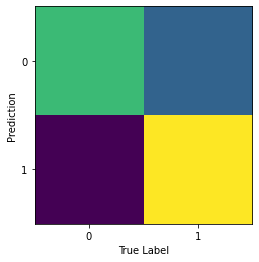

In [ ]:
c_matrix = tf.math.confusion_matrix(Y_preds, X_preds, num_classes=2)
print(c_matrix)
plt.imshow(c_matrix)
plt.xlabel('True Label')
plt.xticks(np.arange(2), [x for x in range(0, 2)])
plt.ylabel('Prediction')
plt.yticks(np.arange(2), [x for x in range(0, 2)])
plt.savefig('MC_OPT_L1L2_CM_final.pdf')
plt.show()